# TFM PROCESO CODIGO

## Pasos a llevar a cabo

1. Preparar el entorno descargando los paquetes que hagan falta en el proceso GWAS
2. Cargar y preprocesamiento de los archivos
3. Control de calidad y limpieza de datos
4. Análisis de asociación (PLINK)
5. Metaanálisis (METAL)
6. Visualizar los resultados del metaanálisis
7. Mapeado de rsIDs
8. Representar resultados mapeado
9. Interpretación funcional

<style>
div.output_area pre {
    white-space: pre;
    overflow-x: auto;
}
div.input_area pre {
    white-space: pre;
    overflow-x: auto;
}
</style>

### 1. Descarga de paquetes

Descargar los paquetes y softwares necesarios para llevar a cabo el estudio

In [186]:
import importlib
import sys

# Lista de paquetes a comprobar e instalar si es necesario
required_packages = [
    "numpy",#operaciones matemáticas y manejo eficiente de arrays
    "pandas",#carga y análisis de datos en tablas (.csv, .tsv, etc.)
    "matplotlib",#generación de gráficos y visualizaciones estadísticas
    "seaborn",#generación de gráficos y visualizaciones estadísticas
    "scikit-learn",#herramientas para machine learning y análisis multivariante
    "statsmodels",#modelos estadísticos clásicos
    "scikit-allel",#análisis de datos genómicos en formato VCF
    "biopython",#manipulación general de secuencias y archivos biológicos
    "pyplink",#leer y manipular archivos en formato PLINK
    "cyvcf2",#lectura rápida y eficiente de archivos VCF
    "ipykernel",#permite que Jupyter Notebook ejecute el entorno correctamente
    "matplotlib_venn",#generación de graficos Venn
    "gseapy",#analisis de enriquecimiento de genes
    "mygene"#acceder y consultar información de anotación genética en API
]

# Función para instalar el paquete si no está presente
def install_if_missing(package): # definimos la función
    try:
        # Comprobar si esta instalado importamos el paquete
        importlib.import_module(package) 
        print(f"{package} ya está instalado.")
    except ImportError: # en caso de no estar instalado haz lo siguiente
        print(f"Instalando {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package]) 
        # ejecutar comando del sistema desde Python y dando la ruta al 
        # ejecutable y ejecutar el módulo gestor de paquete de python (pip)
        # por último señalar el nombre del paquete a instalar 

# Ejecutar la instalación condicional
for pkg in required_packages: 
    # usar 'for' para recorrer la función recién creada 
    # para todos los elementos de la lista de paquetes
    install_if_missing(pkg)

# para trabajar con el sistema operativo (rutas, variables de entorno, etc.)
import os 
# ofrece funciones para copiar, mover y comprobar archivos
import shutil 

#Proceso para instalar PLINK
#Crear una variable con la ruta donde estaría PLINK si esta instalada
plink_path = os.path.expanduser("~/bin/plink") 

# Comprobar si PLINK está en el PATH del sistema o en la ruta esperada
if shutil.which("plink") or os.path.exists(plink_path): 
    print("PLINK ya está instalado y disponible.")
else:
    print("Instalando PLINK...")
    # crear carpeta bin en caso de no existir
    os.makedirs(os.path.expanduser("~/bin"), exist_ok=True) 
    # descargar el ZIP de PLINK desde su servidor
    !wget -q https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20220402.zip -O ~/bin/plink.zip 
    # descomprimir el archivo ZIP
    !unzip -o -q ~/bin/plink.zip -d ~/bin 
    # dar permisos de ejecución para que se pueda usar como un comando
    !chmod +x ~/bin/plink 
    # borrar el ZIP descargado
    !rm ~/bin/plink.zip 
    # añadir bin a la variable PATH durante esta sesión
    os.environ['PATH'] += os.pathsep + os.path.expanduser('~/bin') 
    print("PLINK instalado correctamente.")

# Verificar instalación de PLINK
!plink --version

numpy ya está instalado.
pandas ya está instalado.
matplotlib ya está instalado.
seaborn ya está instalado.
Instalando scikit-learn...
statsmodels ya está instalado.
Instalando scikit-allel...
Instalando biopython...
pyplink ya está instalado.
cyvcf2 ya está instalado.
ipykernel ya está instalado.
matplotlib_venn ya está instalado.
gseapy ya está instalado.
mygene ya está instalado.
Instalando networkx...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.2 MB/s eta 0:00:00
PLINK ya está instalado y disponible.
PLINK v1.90b6.26 64-bit (2 Apr 2022)


In [11]:
# PAQUETES NECESARIOS PARA EL ESTUDIO
#Llamar programas externos (en este caso, PLINK)
import subprocess 
#Para manejar rutas y carpetas
import os 
#Para descomprimir archivos zip
import zipfile 
#Para descomprimir archivos tar.gz
import tarfile 
#Para manejar tablas de datos
import pandas as pd 
#Para mover carpetas o archivos
import shutil
#Buscar archivos buscando patrón en el nombre
import glob 
#expresiones regulares
import re
#operaciones matemáticas con arrays y matrices
import numpy as np 
#Librería principal de gráficos
import matplotlib.pyplot as plt
#Manejo de rutas
from pathlib import Path
#correciones estadísticas para p-values en análisis de enriquecimiento
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
#Hacer diagramas de Venn de tres conjuntos
from matplotlib_venn import venn3 
#Hacer diagramas de Venn de dos conjuntos
from matplotlib_venn import venn2 
#Acceder a la base de datos MyGene.info (conversión ID ensembl -> Symbol)
import mygene
#Análisis de enriquecimiento funcional
import gseapy as gp 

### 2. Carga y preprocesamiento de los archivos

In [240]:
# 1. Definir rutas del input y output files

# Lista de archivos .zip .gz a descomprimir
input_files = [
    "ADNI_1_GWAS_Plink.zip",
    "ADNI_GO2_PLINK_set_1_9.zip",
    "ADNI_GO2_PLINK_set_10_15.tar.gz",
    "ADNI3_PLINKFinalSet1.tar.gz",
    "ADNI3_PLINKFinalSet2.tar.gz"
]

# Carpeta de salida
output_dir = "adni_all_plink"
#Crear la carpeta adni_all_plink, si no existe
os.makedirs(output_dir, exist_ok=True) 

In [237]:
# 2. Extraer todos los archivos descargados en .zip o .tar.gz

for f in input_files:
    print(f"Extrayendo {f} ...")
    # En caso de terminar el archivo por .zip sigue este comando
    if f.endswith(".zip"): 
        # Leer el archivo ZIP (r de read) y con 'with ... as' cerrar 
        # el archivo ZIP una vez terminado el proceso
        with zipfile.ZipFile(f, 'r') as z: 
            #Extraer todo lo del ZIP en la ruta marcada anteriormente
            z.extractall(output_dir) 
    #En caso de terminar con .tar.gz sigue este otro comando
    elif f.endswith(".tar.gz"): 
        # Leer archivo .gz y cerrar el proceso una vez terminado
        with tarfile.open(f, "r:gz") as t: 
            t.extractall(output_dir)
    else:
        # En caso de no reconocer el formato en que estan los archivos
        print(f"Formato no reconocido: {f}")

print(f"\nTodos los archivos extraídos en:", output_dir)

Extrayendo /home/jfabrechguell/miniconda3/TFM/ADNI_1_GWAS_Plink.zip ...
Extrayendo /home/jfabrechguell/miniconda3/TFM/ADNI_GO2_PLINK_set_1_9.zip ...
Extrayendo /home/jfabrechguell/miniconda3/TFM/ADNI_GO2_PLINK_set_10_15.tar.gz ...


/tmp/ipykernel_5358/680164220.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall(output_dir)


Extrayendo /home/jfabrechguell/miniconda3/TFM/ADNI3_PLINKFinalSet1.tar.gz ...
Extrayendo /home/jfabrechguell/miniconda3/TFM/ADNI3_PLINKFinalSet2.tar.gz ...

Todos los archivos extraídos en: /home/jfabrechguell/miniconda3/TFM/adni_all_plink


En los datos el ADNI 1 esta con genoma de referencia GRCh36, por lo que se tiene que pasar al GRCh37 para poder trabajar con todos los datos a la vez.

In [233]:
# 3. Pasar el ADNI 1 al genoma de referencia GRCh37

# Leer el archivo BIM 
bim_file = "adni_all_plink/ADNI_1_gwas.bim"  
# Indicar el separador y que no hay encabezados en el archivo
bim = pd.read_csv(bim_file, sep="\t", header=None)
# Dar nombres a las columnas para hacer mas facil su referencia
bim.columns = ["CHR", "SNP", "CM", "BP", "A1", "A2"]

print("Archivo BIM cargado:", bim.shape)

# Convertir a formato BED UCSC
# UCSC necesita: chr, start, end, name; donde start = BP-1, end = BP
bed = pd.DataFrame({
    # Añadir chr a la columna CHR para el formato de BED UCSC -> 1 = chr1
    "chr": ["chr" + str(c) for c in bim["CHR"]],
    "start": bim["BP"] - 1,
    "end": bim["BP"],
    "name": bim["SNP"]
})

# Ruta del archivo de salida preparado para BED UCSC
bed_file = "adni_all_plink/ADNI1_UCSC.bed"
# Guardar archivo en (ruta, tipo separador, encabezado(False o True)
# index(False o True) para añadir la columna índice del DataFrame)
bed.to_csv(bed_file, sep="\t", header=False, index=False)
print("Archivo BED UCSC generado:", bed_file)

Archivo BIM cargado: (620901, 6)
Archivo BED UCSC generado: adni_all_plink/ADNI1_UCSC.bed


Se usó LiftOver (https://genome.ucsc.edu/cgi-bin/hgLiftOver) para convertir archivo .bed del ADNI 1 correspondiente al genoma de referencia GRCh36 al GRCh37, resultado del cual  se convirtieron 600310 SNPs y fallaron en la conversión 20591. Archivo en: ../../Descargas/hglft_genome_1ccede_8aa70.bed

In [234]:
# Leer archivo BED de salida de LiftOver 
# Este archivo tendrá: chr, start, end, rsID, strand
# Ruta archivo BED
lifted_file = "../../Descargas/hglft_genome_1ccede_8aa70.bed"
# Leer archivo
lifted = pd.read_csv(lifted_file, sep="\t", header=None)
lifted.columns = ["chr", "start", "end", "SNP", "strand"]

print("Archivo BED levantado de LiftOver:", lifted.shape)

# Construir un nuevo BIM con el BED de LiftOver y el BIM anterior
# Unir con el BIM original para recuperar CHR, CM, A1 y A2 de argumento
# de .merge poner los dos archivos a unir, la columna por la que se hace 
# unión (on) inner devuelve solo registros que se encuentran en ambos archivos
merged = pd.merge(lifted, bim, on="SNP", how="inner")

# Reemplazar las posiciones BP con las nuevas (columna 'end'= BP)
# Reemplazar también el chr de la columna CHR por nada
merged["CHR"] = merged["chr"].str.replace("chr", "")
merged["BP"] = merged["end"]

# Marcar el orden de las columnas para PLINK 
bim_new = merged[["CHR", "SNP", "CM", "BP", "A1", "A2"]]

# Guardar el nuevo BIM
bim_new_file = "adni_all_plink/ADNI_1.bim"
bim_new.to_csv(bim_new_file, sep="\t", header=False, index=False)
print("Archivo BIM reconstruido:", bim_new_file)

Archivo BED levantado de LiftOver: (600310, 5)
Archivo BIM reconstruido: adni_all_plink/ADNI_1.bim


Como PLINK trabaja con los archivos .bed .fam y .bim a la vez para hacer la asociación se tiene que reajustar los archivos .bed y .fam con los datos existentes en el nuevo archivo .bim.

In [235]:
# 4. Modificar archivos BED y FAM con el BIM
new = pd.read_csv("adni_all_plink/ADNI_1.bim", sep="\t", header=None)
# Hacer una lista solo con los datos de la columna de SNPs
new[1].to_csv("new_snps.txt", index=False, header=False)
out = "adni_all_plink/ADNI_1"
# Con extract se eliminaran, en los archivos BED y FAM, todos 
# los SNPs que no se encuentren en la lista proporcionada
cmd_bim = [
    "plink",
    "--bfile", "adni_all_plink/ADNI_1_gwas",
    "--extract", "new_snps.txt",
    "--make-bed",
    "--out", out
]
print("Ejecutando:", " ".join(cmd_bim))
subprocess.run(cmd_bim, check=True)

Ejecutando: plink --bfile adni_all_plink/ADNI_1_gwas --extract new_snps.txt --make-bed --out adni_all_plink/ADNI_1
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/ADNI_1.log.
Options in effect:
  --bfile adni_all_plink/ADNI_1_gwas
  --extract new_snps.txt
  --make-bed
  --out adni_all_plink/ADNI_1

7833 MB RAM detected; reserving 3916 MB for main workspace.
620901 variants loaded from .bim file.
757 people (449 males, 308 females) loaded from .fam.
--extract: 600310 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 757 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.955789.
600310 variants and 757 people pass filters and QC.
Note: No phenotypes present.
--make-bed to adni_all_plink/ADNI_1.bed + adni_all_plink/ADNI_1.bim +
adni_all_plink/ADNI_1.

In [241]:
# 5. Combinar los sets del ADNI GO2

# Rutas de los sets y de donde terminara el output
set2_1 = "adni_all_plink/ADNI_GO2_set1_9"
set2_2 = "adni_all_plink/ADNI_GO2_set10_15"
output_dir_2 = "adni_all_plink/merged_ADNI2"
merged_prefix_2 = os.path.join(output_dir_2, "ADNI_2")

# Carpeta de salida
# Crear la carpeta adni_all_plink, si no existe
os.makedirs(output_dir_2, exist_ok=True) 

# Crear archivo merge_list con set2
# os.path.join une una ruta con el nombre proporcionado
merge_list_path_2 = os.path.join(output_dir_2, "ADNI_GO2_merge_list.txt")
# Abrir el archivo y escribir
with open(merge_list_path_2, "w") as f:
    f.write(set2_2 + "\n")

# Comando PLINK para merge
# --merge-list es la lista de archivos que combinar
cmd_merge = [
    "plink",
    "--bfile", set2_1,
    "--merge-list", merge_list_path_2,
    "--make-bed",
    "--out", merged_prefix_2
]
print("Ejecutando:", " ".join(cmd_merge))
subprocess.run(cmd_merge, check=True)

Ejecutando: plink --bfile adni_all_plink/ADNI_GO2_set1_9 --merge-list adni_all_plink/merged_ADNI2/ADNI_GO2_merge_list.txt --make-bed --out adni_all_plink/merged_ADNI2/ADNI_2
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/merged_ADNI2/ADNI_2.log.
Options in effect:
  --bfile adni_all_plink/ADNI_GO2_set1_9
  --make-bed
  --merge-list adni_all_plink/merged_ADNI2/ADNI_GO2_merge_list.txt
  --out adni_all_plink/merged_ADNI2/ADNI_2

7833 MB RAM detected; reserving 3916 MB for main workspace.


Performing single-pass merge (793 people, 730525 variants).
Merged fileset written to adni_all_plink/merged_ADNI2/ADNI_2-merge.bed +
adni_all_plink/merged_ADNI2/ADNI_2-merge.bim +
adni_all_plink/merged_ADNI2/ADNI_2-merge.fam .
730525 variants loaded from .bim file.
793 people (425 males, 368 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 793 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.989008.
730525 variants and 793 people pass filters and QC.
Note: No phenotypes present.
--make-bed to adni_all_plink/merged_ADNI2/ADNI_2.bed +
adni_all_plink/merged_ADNI2/ADNI_2.bim + adni_all_plink/merged_ADNI2/ADNI_2.fam
... 11%

adni_all_plink/merged_ADNI2/ADNI_2.hh ); many commands treat these as missing.
treat these as missing.


done.


Para la asociación se necesita tener la información de fenotipos en el archivo .fam.

In [253]:
# 6. Pasar los fenotipos al archivo .fam

# Rutas de entrada/salida
fam_paths = {
    "ADNI1": "adni_all_plink/ADNI_1.fam",
    "ADNI2": "adni_all_plink/merged_ADNI2/ADNI_2.fam",
    "ADNI3": "adni_all_plink/ADNI_3_set1.fam",
    "ADNI4": "adni_all_plink/ADNI_3_set2.fam"
}

# Archivo descargado del Arc Builder con los fenotipos en la columna DIAGNOSIS
dxsum_path = "DXSUM_01Sep2025.csv" 

# Carpeta de salida
output_fam = "adni_all_plink/ADNI_preprocesamiento"
os.makedirs(output_fam, exist_ok=True)

# Cargar FAM
fam_dfs = {}
for i, fam_path in fam_paths.items():
    fam_df = pd.read_csv(fam_path, sep=r"\s+", header=None)
    fam_dfs[i] = fam_df  # guardamos con la clave (fase)
    print(f"{i}: {fam_df.shape[0]} individuos y {fam_df.shape[1]} columnas cargadas.")

# Cargar DXSUM 
dxsum = pd.read_csv(dxsum_path)

#Procesar los fams
for phase, fam_path in fam_paths.items():
    print(f"\n Procesando {phase} ({fam_path})")

    # Filtrar diagnóstico según fase ADNI1, ADNIGO/2, ADNI3
    if phase == "ADNI1":
        phase_filter = dxsum["PHASE"] == "ADNI1"
    elif phase == "ADNI2":
        phase_filter = dxsum["PHASE"].isin(["ADNI2", "ADNIGO"])
    elif phase == "ADNI3":
        phase_filter = dxsum["PHASE"] == "ADNI3"
    elif phase == "ADNI4":
        phase_filter = dxsum["PHASE"] == "ADNI3"
    else:
        print(f"No se reconoce la fase {phase}, se omite.")
        continue

    dxsum_phase = dxsum[phase_filter]
    
    # Dentro de la fase, quedarse con la visita más reciente por PTID
    # Un mismo paciente puede haber visitado mas de una vez
    dxsum_phase = (
        # Ordenar por la fecha de examen
        dxsum_phase.sort_values("EXAMDATE")
                    # Para evitar duplicados
                   .drop_duplicates(subset="PTID", keep="last")
    )

    # Hacer lista solo con PTID y DIAGNOSIS
    dxsum_subset = dxsum_phase[["PTID", "DIAGNOSIS"]]
    
    # Cargar FAM
    fam_df = pd.read_csv(fam_path, sep=" ", header=None)

    # Hacer merge entre lista y FAM
    fam_merged = pd.merge(
        fam_df,
        dxsum_subset,
        left_on=1,   # columna 2 del .fam = IID
        right_on="PTID",
        how="left"
    )

    # Sustituir fenotipo (-9) por el que aparece en la lista
    fam_merged.iloc[:, 5] = fam_merged["DIAGNOSIS"].fillna(-9).astype(int)

    # Guardar nuevo .fam
    fam_final = fam_merged.iloc[:, :6]
    # os.path.basename permite separar el nombre de un archivo de su ruta
    output_fam_all = os.path.join(output_fam, os.path.basename(fam_path))
    # Guardar archivo separado por espacios
    fam_final.to_csv(output_fam_all, sep=" ", header=False, index=False)

    print(f"Guardado: {output_fam}")

ADNI1: 757 individuos y 6 columnas cargadas.
ADNI2: 793 individuos y 6 columnas cargadas.
ADNI3: 327 individuos y 6 columnas cargadas.
ADNI4: 328 individuos y 6 columnas cargadas.

 Procesando ADNI1 (adni_all_plink/ADNI_1.fam)
Guardado: adni_all_plink/ADNI_preprocesamiento

 Procesando ADNI2 (adni_all_plink/merged_ADNI2/ADNI_2.fam)
Guardado: adni_all_plink/ADNI_preprocesamiento

 Procesando ADNI3 (adni_all_plink/ADNI_3_set1.fam)
Guardado: adni_all_plink/ADNI_preprocesamiento

 Procesando ADNI4 (adni_all_plink/ADNI_3_set2.fam)
Guardado: adni_all_plink/ADNI_preprocesamiento


Para que no de error añadir el sexo a los conjuntos de datos del ADNI 3.

In [254]:
# 7. Pasar el sexo al archivo ADNI_3_set1 y 2.fam

# Rutas de entrada/salida
gender_path = [
    "adni_all_plink/ADNI_before_QC/ADNI_3_set1.fam",
    "adni_all_plink/ADNI_before_QC/ADNI_3_set2.fam"
]
# Archivo descargado del Arc Builder con Gender en una columna
ptdemog_path = "PTDEMOG_01Sep2025.csv" 
output_gender = "adni_all_plink/ADNI_preprocesamiento"

# Cargar GENDER
for g in gender_path:
    gender_df = pd.read_csv(g, sep=" ", header=None)

    # Cargar PTDEMOG y filtrar solo ADNI3
    ptdemog = pd.read_csv(ptdemog_path)

    # Ajustar a la columna PHASE
    ptdemog_adni3 = ptdemog[ptdemog["PHASE"] == "ADNI3"]

    # Hacer lista con solo PTID y PTGENDER
    ptdemog_subset = ptdemog_adni3[["PTID", "PTGENDER"]]

    # Merge con FAM
    fam_merged_3 = pd.merge(
        gender_df,
        ptdemog_subset,
        left_on=1,   # columna 2 del .fam (IID)
        right_on="PTID",
        how="left"
    )

    # Sustituir genero (0) por PTGENDER cuando exista
    fam_merged_3.iloc[:, 4] = fam_merged_3["PTGENDER"].fillna(0).astype(int)

    # Guardar nuevo FAM
    # FAM con solo con las 6 columnas originales
    fam_final_3 = fam_merged_3.iloc[:, :6]  
    output_gender_all = os.path.join(output_gender, os.path.basename(g))
    fam_final_3.to_csv(output_gender_all, sep=" ", header=False, index=False)

    print(f"Archivo .fam actualizado con fenotipos guardado en: {output_fam}")

Archivo .fam actualizado con fenotipos guardado en: adni_all_plink/ADNI_preprocesamiento
Archivo .fam actualizado con fenotipos guardado en: adni_all_plink/ADNI_preprocesamiento


In [20]:
# 8. Mover los BED y BIM a la misma carpeta

# Rutas carpetas
ADNI_1_3 = "adni_all_plink"
ADNI_2 = "adni_all_plink/merged_ADNI2"
final = "adni_all_plink/ADNI_preprocesamiento"

# Buscar archivos ADNI_1.bed y ADNI_1.bim, lo mismo con ADNI_3 y 
# copiarlos en la ruta con FAM para hacer la asociación
for file in glob.glob(os.path.join(ADNI_1_3, "ADNI_1.bed")) + glob.glob(os.path.join(ADNI_1_3, "ADNI_1.bim")) + glob.glob(os.path.join(ADNI_1_3, "ADNI_3*.bed")) + glob.glob(os.path.join(ADNI_1_3, "ADNI_3*.bim")):
    # Función para copiar un archivo de una ruta a otra
    shutil.copy(file, final)
    print(f"Copiado: {file} → {final}")

# Buscar todos los .bed y .bim en carpeta merged_ADNI2
for file in glob.glob(os.path.join(ADNI_2, "*.bed")) + glob.glob(os.path.join(ADNI_2, "*.bim")):
    shutil.copy(file, final)  # usa move si prefieres mover
    print(f"Copiado: {file} → {final}")

Copiado: adni_all_plink/ADNI_1.bed → adni_all_plink/ADNI_preprocesamiento
Copiado: adni_all_plink/ADNI_1.bim → adni_all_plink/ADNI_preprocesamiento
Copiado: adni_all_plink/ADNI_3_set2.bed → adni_all_plink/ADNI_preprocesamiento
Copiado: adni_all_plink/ADNI_3_set1.bed → adni_all_plink/ADNI_preprocesamiento
Copiado: adni_all_plink/ADNI_3_set1.bim → adni_all_plink/ADNI_preprocesamiento
Copiado: adni_all_plink/ADNI_3_set2.bim → adni_all_plink/ADNI_preprocesamiento
Copiado: adni_all_plink/merged_ADNI2/ADNI_2.bed → adni_all_plink/ADNI_preprocesamiento
Copiado: adni_all_plink/merged_ADNI2/ADNI_2.bim → adni_all_plink/ADNI_preprocesamiento


Para evitar errores o lectura errónea eliminar SNPs ambiguos

In [281]:
# 9. Eliminar SNPs ambiguos (A/T o C/G)

# Lista de datasets base (sin extensión)
datasets = [
    "adni_all_plink/ADNI_preprocesamiento/ADNI_1",
    "adni_all_plink/ADNI_preprocesamiento/ADNI_2",
    "adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1",
    "adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2"
]

# Función para detectar SNPs ambiguos
def is_ambiguous(a1, a2):
    pair = {a1, a2}
    return pair in [{"A", "T"}, {"T", "A"}, {"C", "G"}, {"G", "C"}]

# Procesar cada dataset
for dataset in datasets:
    print(f"\nProcesando dataset: {dataset}")
    # Leer el archivo BIM de cada dataset
    bim_file = f"{dataset}.bim"
    bim = pd.read_csv(bim_file, sep="\t", header=None)
    bim.columns = ["CHR", "SNP", "CM", "BP", "A1", "A2"]

    # Identificar ambiguos
    # Describir condición para considerarse SNP ambiguo
    bim["ambiguous"] = bim.apply(lambda row: is_ambiguous(row["A1"], row["A2"]), axis=1)
    ambiguous_snps = bim[bim["ambiguous"]]["SNP"]
    print(f"SNPs ambiguos detectados: {len(ambiguous_snps)}")

    # Guardar lista de SNPs válidos
    valid_snps = bim[~bim["ambiguous"]]["SNP"]
    valid_file = f"{dataset}_valid_snplist.txt"
    valid_snps.to_csv(valid_file, index=False, header=False)
    print(f"SNPs validos detectados: {len(valid_snps)}")
    print(f"Guardado SNPs válidos en {valid_file}")

    out = f"{dataset}_filtered"
    # Usar PLINK para crear nuevo dataset filtrado
    cmd = [
        "plink",
        "--bfile", dataset,
        "--extract", valid_file,
        "--make-bed",
        "--out", out
    ]
    print("Ejecutando:", " ".join(cmd))
    subprocess.run(cmd, check=True)


Procesando dataset: adni_all_plink/ADNI_preprocesamiento/ADNI_1
SNPs ambiguos detectados: 3072
SNPs validos detectados: 597238
Guardado SNPs válidos en adni_all_plink/ADNI_preprocesamiento/ADNI_1_valid_snplist.txt
Ejecutando: plink --bfile adni_all_plink/ADNI_preprocesamiento/ADNI_1 --extract adni_all_plink/ADNI_preprocesamiento/ADNI_1_valid_snplist.txt --make-bed --out adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered.log.
Options in effect:
  --bfile adni_all_plink/ADNI_preprocesamiento/ADNI_1
  --extract adni_all_plink/ADNI_preprocesamiento/ADNI_1_valid_snplist.txt
  --make-bed
  --out adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered

7833 MB RAM detected; reserving 3916 MB for main workspace.
600310 variants loaded from .bim file.
757 people (449 males, 30

adni_all_plink/ADNI_preprocesamiento/ADNI_2_filtered.hh ); many commands treat
these as missing.
treat these as missing.


99%
Procesando dataset: adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1
done.
SNPs ambiguos detectados: 6298
SNPs validos detectados: 753695
Guardado SNPs válidos en adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_valid_snplist.txt
Ejecutando: plink --bfile adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1 --extract adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_valid_snplist.txt --make-bed --out adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered.log.
Options in effect:
  --bfile adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1
  --extract adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_valid_snplist.txt
  --make-bed
  --out adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered

7833 MB RAM detected; reserving 3916 MB for main workspace.
759993 var

adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered.hh ); many commands
treat these as missing.
treat these as missing.


done.

Procesando dataset: adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2
SNPs ambiguos detectados: 5620
SNPs validos detectados: 648407
Guardado SNPs válidos en adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_valid_snplist.txt
Ejecutando: plink --bfile adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2 --extract adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_valid_snplist.txt --make-bed --out adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered.log.
Options in effect:
  --bfile adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2
  --extract adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_valid_snplist.txt
  --make-bed
  --out adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered

7833 MB RAM detected; reserving 3916 MB for main workspace.
654027 varian

adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered.hh ); many commands
treat these as missing.
treat these as missing.


done.


In [284]:
# 10. Armonizar los IDs a rsID

# Lista de datasets base (sin extensión)
datasets_filtered = [
    "adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered",
    "adni_all_plink/ADNI_preprocesamiento/ADNI_2_filtered",
    "adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered",
    "adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered"
]
# Función para normalizar IDs a formato rsID
# Función para normalizar MarkerName
def normalize_marker(name, chr_val=None, bp_val=None, a1=None, a2=None):
    # Si es un rsID → dejar como está
    if name.lower().startswith("rs"):
        return name
    
    # Si tiene dentro "rs1234" → extraerlo
    m = re.search(r"(rs\d+)", name, re.IGNORECASE)
    if m:
        return m.group(1)
    
    # 3. Si es algo como chr:pos o ilmnseq → convertir a chr:bp:a1:a2
    if chr_val is not None and bp_val is not None and a1 is not None and a2 is not None:
        return f"{chr_val}:{bp_val}:{a1}:{a2}"
    
    # 4. Si no se puede normalizar → devolver el original
    return name

# Procesar cada dataset
for dataset in datasets_filtered:
    print(f"\nProcesando dataset: {os.path.basename(dataset)}")
    # Leer dataset y indicar columnas para referirse a ellas
    bim_file = f"{dataset}.bim"
    bim = pd.read_csv(bim_file, sep="\t", header=None)
    bim.columns = ["CHR", "SNP", "CM", "BP", "A1", "A2"]

    # Normalizar IDs aplicando la función creada
    bim["SNP_clean"] = bim["SNP"].apply(normalize_snp_id)

    # Contar cambios
    cambios = (bim["SNP"] != bim["SNP_clean"]).sum()
    print(f"SNPs renombrados a rsID: {cambios}")

    # Guardar nuevo BIM
    new_bim_file = f"{dataset}_clean.bim"
    bim_out = bim[["CHR", "SNP_clean", "CM", "BP", "A1", "A2"]]
    bim_out.to_csv(new_bim_file, sep="\t", header=False, index=False)

    # Copiar .fam y .bed originales (solo .bim cambia)
    fam_file = f"{dataset}.fam"
    bed_file = f"{dataset}.bed"

    # Crear dataset corregido con PLINK
    plink_cmd = [
        "plink",
        "--bed", bed_file,
        "--bim", new_bim_file,
        "--fam", fam_file,
        "--make-bed",
        "--out", f"{dataset}_clean"
    ]
    print("   Ejecutando:", " ".join(plink_cmd))
    subprocess.run(plink_cmd)


Procesando dataset: ADNI_1_filtered
SNPs renombrados a rsID: 0
   Ejecutando: plink --bed adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered.bed --bim adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered_clean.bim --fam adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered.fam --make-bed --out adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered_clean
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered_clean.log.
Options in effect:
  --bed adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered.bed
  --bim adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered_clean.bim
  --fam adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered.fam
  --make-bed
  --out adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered_clean

7833 MB RAM detected; reserving 3916 MB for main workspace.
597238 variants loaded from .bim file.
757 people 

adni_all_plink/ADNI_preprocesamiento/ADNI_2_filtered_clean.hh ); many commands
treat these as missing.
treat these as missing.


done.

Procesando dataset: ADNI_3_set1_filtered
SNPs renombrados a rsID: 352897
   Ejecutando: plink --bed adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered.bed --bim adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered_clean.bim --fam adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered.fam --make-bed --out adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered_clean
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered_clean.log.
Options in effect:
  --bed adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered.bed
  --bim adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered_clean.bim
  --fam adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered.fam
  --make-bed
  --out adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered_clean

7833 MB RAM detected; reserving 3916 MB for main 

adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered_clean.hh ); many
commands treat these as missing.
treat these as missing.


done.

Procesando dataset: ADNI_3_set2_filtered
SNPs renombrados a rsID: 295782
   Ejecutando: plink --bed adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered.bed --bim adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered_clean.bim --fam adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered.fam --make-bed --out adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered_clean
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered_clean.log.
Options in effect:
  --bed adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered.bed
  --bim adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered_clean.bim
  --fam adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered.fam
  --make-bed
  --out adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered_clean

7833 MB RAM detected; reserving 3916 MB for main 

adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered_clean.hh ); many
commands treat these as missing.
treat these as missing.


done.


In [289]:
# 11. Comprobar existencia de duplicados
# Carpeta donde consultar existencia duplicados
final = "adni_all_plink/ADNI_preprocesamiento"

fam_files = []
#recorre la ruta proporcionada y devuelve tupla con ruta, subcarpetas y nombres de archivos
for root, dirs, files in os.walk(final): 
    #Iterando por la carpeta root
    for file in files: 
        #Si el archivo termina en .fam
        if file.endswith("clean.fam"): 
            #Enlaza la ruta al prefijo y la añade a la lista fam_files
            fam_files.append(os.path.join(root, file)) 

all_ids = []
fam_dic = {}

# Agrupar todos los IDs existentes en los archivos FAM
for fam_file in fam_files:
    df = pd.read_csv(fam_file, sep=" ", header=None)
    ids = df[1].tolist()  # columna 2 = IID
    fam_dic[fam_file] = set(ids)
    all_ids.extend(ids)

# Encontrar duplicados globales
duplicated_ids = pd.Series(all_ids).value_counts()
duplicated_ids = duplicated_ids[duplicated_ids > 1].index.tolist()

# Guardar lista global de duplicados
remove_file = "adni_all_plink/duplicated_ids.txt"
with open(remove_file, "w") as f:
    for iid in duplicated_ids:
        f.write(f"1 {iid}\n")   # FID = 1, IID = duplicado

print(f"Se encontraron {len(duplicated_ids)} IDs duplicados")

# Bucle para saber en que archivos y que SNPs estan duplicados
for file in fam_files:
    df = pd.read_csv(file, sep=" ", header=None)
    for dup in duplicated_ids:
        if dup in df[1].values:
            print(f"{dup} encontrado en {os.path.basename(file)}")

Se encontraron 2 IDs duplicados
073_S_0909 encontrado en ADNI_1_filtered_clean.fam
130_S_1201 encontrado en ADNI_1_filtered_clean.fam
073_S_0909 encontrado en ADNI_3_set2_filtered_clean.fam
130_S_1201 encontrado en ADNI_3_set2_filtered_clean.fam


In [290]:
# 12. Guardar los duplicados en un archivo de texto
remove_file = "adni_all_plink/duplicated_ids.txt"
archivo = "adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered_clean"

df = pd.read_csv(f"{archivo}.fam", sep=" ", header=None)

with open(remove_file, "w") as f:
    for iid in duplicated_ids:
        fid = df.loc[df[1] == iid, 0].values[0]  
        f.write(f"{fid} {iid}\n")

print(f"Archivo creado: {remove_file}")

Archivo creado: adni_all_plink/duplicated_ids.txt


In [298]:
# 13. Eliminar los IDs duplicados en uno de los sets
# --remove elimina los datos que aparecen en la lista del archvio proporcionado
output_pre = "adni_all_plink/ADNI_before_QC"
os.makedirs(output_pre, exist_ok=True)

cmd_dup = [
    "plink",
    "--bfile", archivo,
    "--remove", remove_file,
    "--make-bed",
    "--out", "adni_all_plink/ADNI_before_QC/ADNI_1_gwas_no_dup"
]
print("Ejecutando:", " ".join(cmd_dup))
subprocess.run(cmd_dup, check=True)
print(f"Eliminados {len(duplicated_ids)} IIDs de {archivo}")

Ejecutando: plink --bfile adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered_clean --remove adni_all_plink/duplicated_ids.txt --make-bed --out adni_all_plink/ADNI_before_QC/ADNI_1_gwas_no_dup
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/ADNI_before_QC/ADNI_1_gwas_no_dup.log.
Options in effect:
  --bfile adni_all_plink/ADNI_preprocesamiento/ADNI_1_filtered_clean
  --make-bed
  --out adni_all_plink/ADNI_before_QC/ADNI_1_gwas_no_dup
  --remove adni_all_plink/duplicated_ids.txt

7833 MB RAM detected; reserving 3916 MB for main workspace.
597238 variants loaded from .bim file.
757 people (449 males, 308 females) loaded from .fam.
757 phenotype values loaded from .fam.
--remove: 755 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 755 founders and 0 nonfounders present.
Calculating allele frequencies

In [294]:
# 14. Mover los ADNI_1 a otra carpeta
# Rutas carpetas
ADNI = "adni_all_plink/ADNI_preprocesamiento"
final = "adni_all_plink/ADNI_before_QC"

# Buscar archivos por nombre
for file2 in glob.glob(os.path.join(ADNI, "ADNI_2_*_clean.*")):
    shutil.copy(file2, final)
    print(f"{file2} movido a {final}")
for file3 in glob.glob(os.path.join(ADNI, "ADNI_3_*_clean.*")):
    shutil.copy(file3, final)
    print(f"{file3} movido a {final}")

adni_all_plink/ADNI_preprocesamiento/ADNI_2_filtered_clean.bim movido a adni_all_plink/ADNI_before_QC
adni_all_plink/ADNI_preprocesamiento/ADNI_2_filtered_clean.hh movido a adni_all_plink/ADNI_before_QC
adni_all_plink/ADNI_preprocesamiento/ADNI_2_filtered_clean.bed movido a adni_all_plink/ADNI_before_QC
adni_all_plink/ADNI_preprocesamiento/ADNI_2_filtered_clean.fam movido a adni_all_plink/ADNI_before_QC
adni_all_plink/ADNI_preprocesamiento/ADNI_2_filtered_clean.log movido a adni_all_plink/ADNI_before_QC
adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered_clean.hh movido a adni_all_plink/ADNI_before_QC
adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered_clean.fam movido a adni_all_plink/ADNI_before_QC
adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered_clean.bed movido a adni_all_plink/ADNI_before_QC
adni_all_plink/ADNI_preprocesamiento/ADNI_3_set1_filtered_clean.log movido a adni_all_plink/ADNI_before_QC
adni_all_plink/ADNI_preprocesamiento/ADNI_3_set2_filtered_clean.

In [13]:
# 15. Localizar datasets PLINK
final = "adni_all_plink/ADNI_before_QC"

# Cada set de datos descargados tiene su correspondiente .bed, .bim y .fam
# Crear lista vacía para poner los prefijos (adni1.bed, prefijo seria adni1)
plink_sets = [] 
for root, dirs, files in os.walk(final): 
    for file in files: 
        #Si el archivo termina en .bed
        if file.endswith(".bed"): 
            #Separa el nombre de la extensión y con [0] se coge el nombre solo
            prefix = os.path.splitext(file)[0] 
            #Enlaza la ruta al prefijo y la añade a la lista plink_sets
            plink_sets.append(os.path.join(root, prefix)) 

# Evitar duplicados con set() y convierte el plink_sets en lista ordenada con sorted()
plink_sets = sorted(set(plink_sets)) 
print("Datasets PLINK encontrados:")
for s in plink_sets:
    print(s) #Muestra la lista de datasets detectados

Datasets PLINK encontrados:
adni_all_plink/ADNI_before_QC/ADNI_1_gwas_no_dup
adni_all_plink/ADNI_before_QC/ADNI_2_filtered_clean
adni_all_plink/ADNI_before_QC/ADNI_3_set1_filtered_clean
adni_all_plink/ADNI_before_QC/ADNI_3_set2_filtered_clean


In [15]:
# Saber cuantos datos tenemos antes al iniciar el estudio
for sets in plink_sets:
    sets_fam = f"{sets}.fam" # Contar filas para saber num. individuos
    sets_bim = f"{sets}.bim" # Contar filas para saber num. SNPs
    setsfam_df = pd.read_csv(sets_fam, sep=r"\s+", header=None)
    setsbim_df = pd.read_csv(sets_bim, sep=r"\s+", header=None)
    print(f"{setsfam_df.shape[0]} individuos y {setsbim_df.shape[0]} SNPs.")

755 individuos y 597238 SNPs.
793 individuos y 728065 SNPs.
327 individuos y 753695 SNPs.
328 individuos y 648407 SNPs.


### 3. Control de calidad y limpieza de datos

In [309]:
#Haremos bucle for para iterar sobre la lista plink_sets y hacer el QC sobre todos los sets seguidos

# Carpeta de salida del Quality Control
QC = "adni_all_plink/Quality_Control"
os.makedirs(QC, exist_ok=True) #Crea la carpeta adni_all_plink, si no existe

for dataset in plink_sets:
    #Nombramos los archivos de salida
    dataset_name = os.path.basename(dataset)
    
    # 1. Filtrar SNPs e individuos con >5% de genotipos faltantes
    step1_out = os.path.join(QC, f"step1_qc_{dataset_name}") #Une el directorio de salida con los nombres
    cmd_qc1 = [
        "plink",
        "--bfile", dataset, #Usa el dataset de los archivos descomprimidos
        "--geno", "0.05", #Elimina SNPs con más de 5% de genotipo faltante
        "--mind", "0.05", #Elimina individuos con más de 5% de genotipos faltantes
        "--make-bed", #Genera un nuevo dataset de PLINK con los SNPs y individuos que pasen el filtro
        "--out", step1_out #Nombre de los archivos de salida
    ]
    print("Ejecutando:", " ".join(cmd_qc1))
    subprocess.run(cmd_qc1, check=True)

    # 2. Filtrar por frecuencia alélica menor (MAF < 0.01)
    step2_out = os.path.join(QC, f"step2_maf_{dataset_name}")
    cmd_qc2 = [
        "plink",
        "--bfile", step1_out, #Usa el dataset del paso anterior
        "--maf", "0.01", #Elimina SNPs con frecuencia alélica menor a 1% (SNPs raros)
        "--make-bed", #Genera un nuevo dataset de PLINK con los SNPs que pasen el filtro
        "--out", step2_out #Nombre de los archivos de salida
    ]
    print("Ejecutando:", " ".join(cmd_qc2))
    subprocess.run(cmd_qc2, check=True)

    # 3. Filtrar SNPs fuera de equilibrio de Hardy-Weinberg (HWE p < 1e-6)
    step3_out = os.path.join(QC, f"{(dataset_name).replace("_filtered_clean", "")}")
    cmd_qc3 = [
        "plink",
        "--bfile", step2_out, #Usa el dataset del paso anterior
        "--hwe", "1e-6", #Elimina SNPs con valor de HWE < 0.000001
        "--make-bed", #Genera un nuevo dataset de PLINK con los SNPs que pasen el filtro
        "--out", step3_out #Nombre de los archivos de salida
    ]
    print("Ejecutando:", " ".join(cmd_qc3))
    subprocess.run(cmd_qc3, check=True)
    
    print(f"\n---- QC completado para {dataset_name}. Resultado final: {step3_out} ----\n")

Ejecutando: plink --bfile adni_all_plink/ADNI_before_QC/ADNI_1_gwas_no_dup --geno 0.05 --mind 0.05 --make-bed --out adni_all_plink/Quality_Control/step1_qc_ADNI_1_gwas_no_dup
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Quality_Control/step1_qc_ADNI_1_gwas_no_dup.log.
Options in effect:
  --bfile adni_all_plink/ADNI_before_QC/ADNI_1_gwas_no_dup
  --geno 0.05
  --make-bed
  --mind 0.05
  --out adni_all_plink/Quality_Control/step1_qc_ADNI_1_gwas_no_dup

7833 MB RAM detected; reserving 3916 MB for main workspace.
597238 variants loaded from .bim file.
755 people (449 males, 306 females) loaded from .fam.
755 phenotype values loaded from .fam.
121 people removed due to missing genotype data (--mind).
IDs written to adni_all_plink/Quality_Control/step1_qc_ADNI_1_gwas_no_dup.irem
.
Using 1 thread (no multithreaded calculations invoked).
Before main varian

adni_all_plink/Quality_Control/step1_qc_ADNI_2_filtered_clean.hh ); many
commands treat these as missing.
treat these as missing.


99%Ejecutando: plink --bfile adni_all_plink/Quality_Control/step1_qc_ADNI_2_filtered_clean --maf 0.01 --make-bed --out adni_all_plink/Quality_Control/step2_maf_ADNI_2_filtered_clean
done.
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Quality_Control/step2_maf_ADNI_2_filtered_clean.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/step1_qc_ADNI_2_filtered_clean
  --maf 0.01
  --make-bed
  --out adni_all_plink/Quality_Control/step2_maf_ADNI_2_filtered_clean

7833 MB RAM detected; reserving 3916 MB for main workspace.
710861 variants loaded from .bim file.
793 people (425 males, 368 females) loaded from .fam.
793 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 793 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.99

adni_all_plink/Quality_Control/step2_maf_ADNI_2_filtered_clean.hh ); many
commands treat these as missing.
treat these as missing.


done.
Ejecutando: plink --bfile adni_all_plink/Quality_Control/step2_maf_ADNI_2_filtered_clean --hwe 1e-6 --make-bed --out adni_all_plink/Quality_Control/ADNI_2
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Quality_Control/ADNI_2.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/step2_maf_ADNI_2_filtered_clean
  --hwe 1e-6
  --make-bed
  --out adni_all_plink/Quality_Control/ADNI_2

7833 MB RAM detected; reserving 3916 MB for main workspace.
650050 variants loaded from .bim file.
793 people (425 males, 368 females) loaded from .fam.
793 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 793 founders and 0 nonfounders present.
Calculating allele frequencies... done.


adni_all_plink/Quality_Control/ADNI_2.hh ); many commands treat these as
missing.
treat these as missing.
chromosome.  You may want to use a less stringent --hwe p-value threshold for X
chromosome variants.


Total genotyping rate is 0.998522.
--hwe: 2589 variants removed due to Hardy-Weinberg exact test.
647461 variants and 793 people pass filters and QC.
Phenotype data is quantitative.
--make-bed to adni_all_plink/Quality_Control/ADNI_2.bed +
adni_all_plink/Quality_Control/ADNI_2.bim +
adni_all_plink/Quality_Control/ADNI_2.fam ... done.

---- QC completado para ADNI_2_filtered_clean. Resultado final: adni_all_plink/Quality_Control/ADNI_2 ----

Ejecutando: plink --bfile adni_all_plink/ADNI_before_QC/ADNI_3_set1_filtered_clean --geno 0.05 --mind 0.05 --make-bed --out adni_all_plink/Quality_Control/step1_qc_ADNI_3_set1_filtered_clean
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Quality_Control/step1_qc_ADNI_3_set1_filtered_clean.log.
Options in effect:
  --bfile adni_all_plink/ADNI_before_QC/ADNI_3_set1_filtered_clean
  --geno 0.05
  --make-bed
  --mind 0

adni_all_plink/Quality_Control/step1_qc_ADNI_3_set1_filtered_clean.hh ); many
commands treat these as missing.
treat these as missing.


done.
Ejecutando: plink --bfile adni_all_plink/Quality_Control/step1_qc_ADNI_3_set1_filtered_clean --maf 0.01 --make-bed --out adni_all_plink/Quality_Control/step2_maf_ADNI_3_set1_filtered_clean
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Quality_Control/step2_maf_ADNI_3_set1_filtered_clean.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/step1_qc_ADNI_3_set1_filtered_clean
  --maf 0.01
  --make-bed
  --out adni_all_plink/Quality_Control/step2_maf_ADNI_3_set1_filtered_clean

7833 MB RAM detected; reserving 3916 MB for main workspace.
743682 variants loaded from .bim file.
327 people (145 males, 182 females) loaded from .fam.
321 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 327 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total g

adni_all_plink/Quality_Control/step2_maf_ADNI_3_set1_filtered_clean.hh ); many
commands treat these as missing.
treat these as missing.


done.
Ejecutando: plink --bfile adni_all_plink/Quality_Control/step2_maf_ADNI_3_set1_filtered_clean --hwe 1e-6 --make-bed --out adni_all_plink/Quality_Control/ADNI_3_set1
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Quality_Control/ADNI_3_set1.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/step2_maf_ADNI_3_set1_filtered_clean
  --hwe 1e-6
  --make-bed
  --out adni_all_plink/Quality_Control/ADNI_3_set1

7833 MB RAM detected; reserving 3916 MB for main workspace.
525901 variants loaded from .bim file.
327 people (145 males, 182 females) loaded from .fam.
321 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 327 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.998711.
--hwe: 857 variants removed due to Hardy-Wein

adni_all_plink/Quality_Control/ADNI_3_set1.hh ); many commands treat these as
missing.
treat these as missing.
chromosome.  You may want to use a less stringent --hwe p-value threshold for X
chromosome variants.


done.

---- QC completado para ADNI_3_set1_filtered_clean. Resultado final: adni_all_plink/Quality_Control/ADNI_3_set1 ----

Ejecutando: plink --bfile adni_all_plink/ADNI_before_QC/ADNI_3_set2_filtered_clean --geno 0.05 --mind 0.05 --make-bed --out adni_all_plink/Quality_Control/step1_qc_ADNI_3_set2_filtered_clean
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Quality_Control/step1_qc_ADNI_3_set2_filtered_clean.log.
Options in effect:
  --bfile adni_all_plink/ADNI_before_QC/ADNI_3_set2_filtered_clean
  --geno 0.05
  --make-bed
  --mind 0.05
  --out adni_all_plink/Quality_Control/step1_qc_ADNI_3_set2_filtered_clean

7833 MB RAM detected; reserving 3916 MB for main workspace.
648407 variants loaded from .bim file.
328 people (152 males, 168 females, 8 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
adni_all_plink/Quality_Control/step1_qc_ADNI_

adni_all_plink/Quality_Control/step1_qc_ADNI_3_set2_filtered_clean.hh ); many
commands treat these as missing.
treat these as missing.


done.
Ejecutando: plink --bfile adni_all_plink/Quality_Control/step1_qc_ADNI_3_set2_filtered_clean --maf 0.01 --make-bed --out adni_all_plink/Quality_Control/step2_maf_ADNI_3_set2_filtered_clean
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Quality_Control/step2_maf_ADNI_3_set2_filtered_clean.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/step1_qc_ADNI_3_set2_filtered_clean
  --maf 0.01
  --make-bed
  --out adni_all_plink/Quality_Control/step2_maf_ADNI_3_set2_filtered_clean

7833 MB RAM detected; reserving 3916 MB for main workspace.
643970 variants loaded from .bim file.
328 people (152 males, 168 females, 8 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
adni_all_plink/Quality_Control/step2_maf_ADNI_3_set2_filtered_clean.nosex .
312 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked)

adni_all_plink/Quality_Control/step2_maf_ADNI_3_set2_filtered_clean.hh ); many
commands treat these as missing.
treat these as missing.


done.
Ejecutando: plink --bfile adni_all_plink/Quality_Control/step2_maf_ADNI_3_set2_filtered_clean --hwe 1e-6 --make-bed --out adni_all_plink/Quality_Control/ADNI_3_set2
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Quality_Control/ADNI_3_set2.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/step2_maf_ADNI_3_set2_filtered_clean
  --hwe 1e-6
  --make-bed
  --out adni_all_plink/Quality_Control/ADNI_3_set2

7833 MB RAM detected; reserving 3916 MB for main workspace.
494182 variants loaded from .bim file.
328 people (152 males, 168 females, 8 ambiguous) loaded from .fam.
Ambiguous sex IDs written to adni_all_plink/Quality_Control/ADNI_3_set2.nosex .
312 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 328 founders and 0 nonfounders present.
Calculating allele frequenc

adni_all_plink/Quality_Control/ADNI_3_set2.hh ); many commands treat these as
missing.
treat these as missing.
chromosome.  You may want to use a less stringent --hwe p-value threshold for X
chromosome variants.


done.

---- QC completado para ADNI_3_set2_filtered_clean. Resultado final: adni_all_plink/Quality_Control/ADNI_3_set2 ----



In [16]:
# Rutas archivos
data = "adni_all_plink/Quality_Control"

# Localizar datasets PLINK
# Cada set de datos descargados tendrá su correspondiente .bed, .bim y .fam
sets_plink = [] #Creamos lista vacía para poner los prefijos (adni1.bed, prefijo seria adni1)
for root, dirs, files in os.walk(data): #recorre la ruta data u dentro de esta devuelve tupla con ruta, subcarpetas y nombres de archivos
    for file in files: #Iterando por la carpeta root
        if file.startswith("ADNI_"): #Si el archivo empieza por ADNI_
            prefix = os.path.splitext(file)[0] #Separa el nombre de la extensión y con [0] se coge el nombre solo
            sets_plink.append(os.path.join(root, prefix)) #Enlaza la ruta al prefijo y la añade a la lista sets_plink

sets_plink = sorted(set(sets_plink)) #Evita duplicados con set() y convierte el plink_sets en lista ordenada con sorted()
print("Datasets PLINK encontrados:")
for s in sets_plink:
    print(s) #Muestra la lista de datasets detectados

Datasets PLINK encontrados:
adni_all_plink/Quality_Control/ADNI_1_gwas_no_dup
adni_all_plink/Quality_Control/ADNI_2
adni_all_plink/Quality_Control/ADNI_3_set1
adni_all_plink/Quality_Control/ADNI_3_set2


In [17]:
# Saber cuantos datos tenemos después del QC
for sets in sets_plink:
    sets_fam = f"{sets}.fam" # Contar filas para saber num. individuos
    sets_bim = f"{sets}.bim" # Contar filas para saber num. SNPs
    setsfam_df = pd.read_csv(sets_fam, sep=r"\s+", header=None)
    setsbim_df = pd.read_csv(sets_bim, sep=r"\s+", header=None)
    print(f"{setsfam_df.shape[0]} individuos y {setsbim_df.shape[0]} SNPs.")

634 individuos y 548560 SNPs.
793 individuos y 647461 SNPs.
327 individuos y 525044 SNPs.
328 individuos y 490729 SNPs.


### 4. Análisis de asociación

In [311]:
# Ruta donde guardar los datos que han pasado el control
asoc = "adni_all_plink/Asociacion"
os.makedirs(asoc, exist_ok=True) #Crea la carpeta adni_all_plink, si no existe

# Asociación de autosomas de los 4 sets
for ADNI in sets_plink:
    # Nombramos los archivos de salida
    ADNI_name = os.path.basename(ADNI)
    # Une el directorio de salida con los nombres
    step_out = os.path.join(asoc, f"{ADNI_name}_autosomas") 
    print(f"---- Empezando la asociación del {ADNI} ----")
    # Codigo del análisis de autosomas (1-22)
    cmd_asoc = [
        "plink",
        "--bfile", ADNI,
        "--chr", "1-22",
        "--set-hh-missing", # Convierte genotipos haploides heterocigotos en missing
        "--linear", "hide-covar", # Regresión lineal y no mostrar las covariables en los resultados
        "--out", step_out
    ]
    print("Ejecutando:", " ".join(cmd_asoc))
    subprocess.run(cmd_asoc, check=True)

    print(f"---- Asociación del {ADNI} completada. Resultados guardados en: {asoc} ----")

---- Empezando la asociación del adni_all_plink/Quality_Control/ADNI_1_gwas_no_dup ----
Ejecutando: plink --bfile adni_all_plink/Quality_Control/ADNI_1_gwas_no_dup --chr 1-22 --set-hh-missing --linear hide-covar --out adni_all_plink/Asociacion/ADNI_1_gwas_no_dup_autosomas
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Asociacion/ADNI_1_gwas_no_dup_autosomas.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/ADNI_1_gwas_no_dup
  --chr 1-22
  --linear hide-covar
  --out adni_all_plink/Asociacion/ADNI_1_gwas_no_dup_autosomas
  --set-hh-missing

7833 MB RAM detected; reserving 3916 MB for main workspace.
548560 variants loaded from .bim file.
634 people (376 males, 258 females) loaded from .fam.
634 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 634 founders and 0 nonfo

In [312]:
#Crear el archivo covar.txt para la asociacion del cromosoma X

#Rutas carpeta covar
covar = "adni_all_plink/Asociacion/covar"
os.makedirs(covar, exist_ok=True) # Crea la carpeta adni_all_plink, si no existe

for ADNI in sets_plink:
    # Nombramos los archivos de salida
    ADNI_name = os.path.basename(ADNI)
    step_out_c = os.path.join(covar, f"pruned_{ADNI_name}") # Une el directorio de salida con los nombres
    # Codigo para crear archivo covar.txt
    # Pruning para SNPs independientes
    cmd_pruned = [
        "plink",
        "--bfile", ADNI,
        "--indep-pairwise", "50", "5", "0.2", # Quitar SNPs redundantes, devuelve lista de SNPs independientes. Análisis con valores estandar
        "--out", step_out_c
    ]
    print("Ejecutando:", " ".join(cmd_pruned))
    subprocess.run(cmd_pruned, check=True)
    
    step_in = os.path.join(covar, f"pruned_{ADNI_name}.prune.in")
    step_out_c2 = os.path.join(covar, f"{ADNI_name}_PCA") # Une el directorio de salida con los nombres
    # PCA en los SNPs pruned
    cmd_pca = [
        "plink",
        "--bfile", ADNI,
        "--extract", step_in,
        "--pca", "10", # Análisis de componentes principales de la variación genética
        "--out", step_out_c2
    ]
    print("Ejecutando:", " ".join(cmd_pca))
    subprocess.run(cmd_pca, check=True)
    
    #Procesar los fams
    cov_fam = pd.read_csv(f"{ADNI}.fam", sep=" ", header=None)
    cov_fam = cov_fam[[0, 1, 4]]
    cov_fam.columns = ['FID', 'IID', 'SEX']
        
    #Leer los eigenvec files
    step_in_pca = os.path.join(covar, f"{ADNI_name}_PCA.eigenvec")
    pca = pd.read_csv(step_in_pca, sep=" ", header=None)
    # Las primeras dos columnas son FID/IID, las otras 10 son PCs
    pca = pca.iloc[:, :12]
    # Asegurar que FID/IID provienen del .fam y no de PCA
    pca.columns = ['FID', 'IID'] + [f'PC{i+1}' for i in range(10)]
        
    # Reemplazar los FID/IID de PCA por los del .fam (que son los correctos)
    pca = pca.drop(columns=['FID', 'IID'])
    merged_eigfam = pd.concat([cov_fam, pca], axis=1)
    
    #Separar por SEX
    males = merged_eigfam[merged_eigfam['SEX'] == 1].drop(columns=['SEX'])
    females = merged_eigfam[merged_eigfam['SEX'] == 2].drop(columns=['SEX'])

    # Descargar archivos covar hombres y covar mujeres
    output_males = os.path.join(covar, f"males_{ADNI_name}.txt")
    males.to_csv(output_males, sep='\t', index=False, header=True)
    output_females = os.path.join(covar, f"females_{ADNI_name}.txt")
    females.to_csv(output_females, sep='\t', index=False, header=True)
    
    print(f"Covar de {ADNI} creado")

Ejecutando: plink --bfile adni_all_plink/Quality_Control/ADNI_1_gwas_no_dup --indep-pairwise 50 5 0.2 --out adni_all_plink/Asociacion/covar/pruned_ADNI_1_gwas_no_dup
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Asociacion/covar/pruned_ADNI_1_gwas_no_dup.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/ADNI_1_gwas_no_dup
  --indep-pairwise 50 5 0.2
  --out adni_all_plink/Asociacion/covar/pruned_ADNI_1_gwas_no_dup

7833 MB RAM detected; reserving 3916 MB for main workspace.
548560 variants loaded from .bim file.
634 people (376 males, 258 females) loaded from .fam.
634 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 634 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.998773.
548560 variants and 634 people pass 

adni_all_plink/Asociacion/covar/pruned_ADNI_2.hh ); many commands treat these
as missing.
treat these as missing.


Pruned 41524 variants from chromosome 1, leaving 10145.
Pruned 41930 variants from chromosome 2, leaving 9431.
Pruned 34309 variants from chromosome 3, leaving 8066.
Pruned 29370 variants from chromosome 4, leaving 7325.
Pruned 30707 variants from chromosome 5, leaving 7504.
Pruned 35364 variants from chromosome 6, leaving 7794.
Pruned 27554 variants from chromosome 7, leaving 6642.
Pruned 27636 variants from chromosome 8, leaving 6068.
Pruned 24103 variants from chromosome 9, leaving 5762.
Pruned 28337 variants from chromosome 10, leaving 6574.
Pruned 26565 variants from chromosome 11, leaving 6085.
Pruned 25377 variants from chromosome 12, leaving 6351.
Pruned 19945 variants from chromosome 13, leaving 4815.
Pruned 16638 variants from chromosome 14, leaving 4237.
Pruned 15351 variants from chromosome 15, leaving 4117.
Pruned 15767 variants from chromosome 16, leaving 4414.
Pruned 13633 variants from chromosome 17, leaving 4097.
Pruned 15186 variants from chromosome 18, leaving 4130.


adni_all_plink/Asociacion/covar/ADNI_2_PCA.hh ); many commands treat these as
missing.
treat these as missing.


Relationship matrix calculation complete.
--pca: Results saved to adni_all_plink/Asociacion/covar/ADNI_2_PCA.eigenval and
adni_all_plink/Asociacion/covar/ADNI_2_PCA.eigenvec .
Covar de adni_all_plink/Quality_Control/ADNI_2 creado
Ejecutando: plink --bfile adni_all_plink/Quality_Control/ADNI_3_set1 --indep-pairwise 50 5 0.2 --out adni_all_plink/Asociacion/covar/pruned_ADNI_3_set1
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Asociacion/covar/pruned_ADNI_3_set1.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/ADNI_3_set1
  --indep-pairwise 50 5 0.2
  --out adni_all_plink/Asociacion/covar/pruned_ADNI_3_set1

7833 MB RAM detected; reserving 3916 MB for main workspace.
525044 variants loaded from .bim file.
327 people (145 males, 182 females) loaded from .fam.
321 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculat

adni_all_plink/Asociacion/covar/pruned_ADNI_3_set1.hh ); many commands treat
these as missing.
treat these as missing.


Pruned 20625 variants from chromosome 3, leaving 14272.
Pruned 19307 variants from chromosome 4, leaving 13464.
Pruned 17324 variants from chromosome 5, leaving 12854.
Pruned 23636 variants from chromosome 6, leaving 12799.
Pruned 16449 variants from chromosome 7, leaving 11574.
Pruned 15463 variants from chromosome 8, leaving 10635.
Pruned 12370 variants from chromosome 9, leaving 9338.
Pruned 14721 variants from chromosome 10, leaving 10708.
Pruned 14590 variants from chromosome 11, leaving 10187.
Pruned 13929 variants from chromosome 12, leaving 10224.
Pruned 10455 variants from chromosome 13, leaving 7666.
Pruned 9462 variants from chromosome 14, leaving 6982.
Pruned 8800 variants from chromosome 15, leaving 6605.
Pruned 9360 variants from chromosome 16, leaving 7281.
Pruned 7984 variants from chromosome 17, leaving 6645.
Pruned 8251 variants from chromosome 18, leaving 6751.
Pruned 6015 variants from chromosome 19, leaving 5254.
Pruned 6781 variants from chromosome 20, leaving 567

adni_all_plink/Asociacion/covar/ADNI_3_set1_PCA.hh ); many commands treat these
as missing.
treat these as missing.


Relationship matrix calculation complete.
--pca: Results saved to and eigenvectors]
adni_all_plink/Asociacion/covar/ADNI_3_set1_PCA.eigenval and
adni_all_plink/Asociacion/covar/ADNI_3_set1_PCA.eigenvec .
Covar de adni_all_plink/Quality_Control/ADNI_3_set1 creado
Ejecutando: plink --bfile adni_all_plink/Quality_Control/ADNI_3_set2 --indep-pairwise 50 5 0.2 --out adni_all_plink/Asociacion/covar/pruned_ADNI_3_set2
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Asociacion/covar/pruned_ADNI_3_set2.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/ADNI_3_set2
  --indep-pairwise 50 5 0.2
  --out adni_all_plink/Asociacion/covar/pruned_ADNI_3_set2

7833 MB RAM detected; reserving 3916 MB for main workspace.
490729 variants loaded from .bim file.
328 people (152 males, 168 females, 8 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
adni_

adni_all_plink/Asociacion/covar/pruned_ADNI_3_set2.hh ); many commands treat
these as missing.
treat these as missing.


Pruned 17072 variants from chromosome 3, leaving 15380.
Pruned 15698 variants from chromosome 4, leaving 14561.
Pruned 14346 variants from chromosome 5, leaving 13721.
Pruned 20458 variants from chromosome 6, leaving 13852.
Pruned 13649 variants from chromosome 7, leaving 12553.
Pruned 12834 variants from chromosome 8, leaving 11480.
Pruned 10196 variants from chromosome 9, leaving 10110.
Pruned 12401 variants from chromosome 10, leaving 11581.
Pruned 12218 variants from chromosome 11, leaving 10969.
Pruned 11696 variants from chromosome 12, leaving 11013.
Pruned 8751 variants from chromosome 13, leaving 8242.
Pruned 7804 variants from chromosome 14, leaving 7544.
Pruned 7391 variants from chromosome 15, leaving 7192.
Pruned 7783 variants from chromosome 16, leaving 7817.
Pruned 6611 variants from chromosome 17, leaving 7205.
Pruned 6782 variants from chromosome 18, leaving 7273.
Pruned 4898 variants from chromosome 19, leaving 5663.
Pruned 5625 variants from chromosome 20, leaving 606

adni_all_plink/Asociacion/covar/ADNI_3_set2_PCA.hh ); many commands treat these
as missing.
treat these as missing.


Relationship matrix calculation complete.
--pca: Results saved to and eigenvectors]
adni_all_plink/Asociacion/covar/ADNI_3_set2_PCA.eigenval and
adni_all_plink/Asociacion/covar/ADNI_3_set2_PCA.eigenvec .
Covar de adni_all_plink/Quality_Control/ADNI_3_set2 creado


In [313]:
print(males) # Ejemplo archivo covar

       FID         IID       PC1       PC2       PC3       PC4       PC5  \
1    ADNI3  002_S_6695  0.039680 -0.018240  0.019721 -0.018272 -0.007875   
3    ADNI3  003_S_6644  0.029148 -0.010308  0.010930  0.224316  0.056737   
8    ADNI3  003_S_6959  0.008657  0.088877 -0.253981 -0.038866 -0.005871   
10   ADNI3  003_S_7010  0.011646  0.061032 -0.181148 -0.010195 -0.008302   
11   ADNI3  006_S_6610  0.038345 -0.017416  0.011334 -0.011115 -0.010351   
..     ...         ...       ...       ...       ...       ...       ...   
318  ADNI3  941_S_6570  0.032040 -0.011668  0.003919  0.105343  0.027495   
321  ADNI3  941_S_6854  0.040149 -0.016459  0.015670 -0.048059 -0.009011   
323  ADNI3  941_S_6998 -0.021226  0.219843  0.070965 -0.019606  0.002685   
326  ADNI3  941_S_7051 -0.077358 -0.022463 -0.000779  0.014621 -0.016368   
327  ADNI3  941_S_7074 -0.020970  0.215752  0.087835 -0.019285 -0.003594   

          PC6       PC7       PC8       PC9      PC10  
1    0.005283 -0.005442  0.0130

In [314]:
# Ruta archivos associacion cromosoma X
covar = "adni_all_plink/Asociacion/covar"
chr_x = "adni_all_plink/Asociacion/chr_x"
os.makedirs(chr_x, exist_ok=True) # Crea la carpeta adni_all_plink, si no existe

for ADNI in sets_plink: 
    #Nombramos los archivos de salida
    ADNI_name = os.path.basename(ADNI)
    if os.path.basename(ADNI) == "ADNI_1_gwas_no_dup":
        print(f"{ADNI_name} no tiene CHR X")
    else:
        step_in_males = os.path.join(covar, f"males_{ADNI_name}.txt")
        step_out_2 = os.path.join(chr_x, f"males_{ADNI_name}") # Une el directorio de salida con los nombres
        print(f"---- Empezando la asociación del cromosoma X por análisis estratificado por sexo de {ADNI} ----")
        # Codigo del análisis del cromosoma X, análisis estratificado por sexo (hombres)
        cmd_mal = [
            "plink",
            "--bfile", ADNI,
            "--chr", "X",
            "--set-hh-missing", # convierte genotipos haploides heterocigotos en missing
            "--linear", "hide-covar",
            "--covar", step_in_males,
            "--covar-name", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", # Columnas archivo covar
            "--out", step_out_2
        ]
        print("Ejecutando:", " ".join(cmd_mal))
        subprocess.run(cmd_mal, check=True)
    
        step_in_females = os.path.join(covar, f"females_{ADNI_name}.txt")
        step_out_3 = os.path.join(chr_x, f"females_{ADNI_name}") #Une el directorio de salida con los nombres
        #Codigo del análisis del cromosoma X, análisis estratificado por sexo (mujeres)
        cmd_fem = [
            "plink",
            "--bfile", ADNI,
            "--chr", "X",
            "--set-hh-missing", # convierte genotipos haploides heterocigotos en missing
            "--linear", "hide-covar",
            "--covar", step_in_females,
            "--covar-name", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10",
            "--out", step_out_3
        ]
        print("Ejecutando:", " ".join(cmd_fem))
        subprocess.run(cmd_fem, check=True)
    
        print(f"---- Asociación del {ADNI_name} completada. Resultados guardados en: {asoc} ----")

ADNI_1_gwas_no_dup no tiene CHR X
---- Empezando la asociación del cromosoma X por análisis estratificado por sexo de adni_all_plink/Quality_Control/ADNI_2 ----
Ejecutando: plink --bfile adni_all_plink/Quality_Control/ADNI_2 --chr X --set-hh-missing --linear hide-covar --covar adni_all_plink/Asociacion/covar/males_ADNI_2.txt --covar-name PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10 --out adni_all_plink/Asociacion/chr_x/males_ADNI_2
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Asociacion/chr_x/males_ADNI_2.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/ADNI_2
  --chr X
  --covar adni_all_plink/Asociacion/covar/males_ADNI_2.txt
  --covar-name PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10
  --linear hide-covar
  --out adni_all_plink/Asociacion/chr_x/males_ADNI_2
  --set-hh-missing

7833 MB RAM detected; reserving 3916 MB for main workspace.
15

adni_all_plink/Asociacion/chr_x/males_ADNI_2.hh ); many commands treat these as
missing.


done.
Ejecutando: plink --bfile adni_all_plink/Quality_Control/ADNI_2 --chr X --set-hh-missing --linear hide-covar --covar adni_all_plink/Asociacion/covar/females_ADNI_2.txt --covar-name PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10 --out adni_all_plink/Asociacion/chr_x/females_ADNI_2
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Asociacion/chr_x/females_ADNI_2.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/ADNI_2
  --chr X
  --covar adni_all_plink/Asociacion/covar/females_ADNI_2.txt
  --covar-name PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10
  --linear hide-covar
  --out adni_all_plink/Asociacion/chr_x/females_ADNI_2
  --set-hh-missing

7833 MB RAM detected; reserving 3916 MB for main workspace.
15240 out of 647461 variants loaded from .bim file.
793 people (425 males, 368 females) loaded from .fam.
793 phenotype values loaded from .fam.
Us

adni_all_plink/Asociacion/chr_x/females_ADNI_2.hh ); many commands treat these
as missing.


done.
---- Asociación del ADNI_2 completada. Resultados guardados en: adni_all_plink/Asociacion ----
---- Empezando la asociación del cromosoma X por análisis estratificado por sexo de adni_all_plink/Quality_Control/ADNI_3_set1 ----
Ejecutando: plink --bfile adni_all_plink/Quality_Control/ADNI_3_set1 --chr X --set-hh-missing --linear hide-covar --covar adni_all_plink/Asociacion/covar/males_ADNI_3_set1.txt --covar-name PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10 --out adni_all_plink/Asociacion/chr_x/males_ADNI_3_set1
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Asociacion/chr_x/males_ADNI_3_set1.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/ADNI_3_set1
  --chr X
  --covar adni_all_plink/Asociacion/covar/males_ADNI_3_set1.txt
  --covar-name PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10
  --linear hide-covar
  --out adni_all_plink/Asociacion

adni_all_plink/Asociacion/chr_x/males_ADNI_3_set1.hh ); many commands treat
these as missing.


done.
Ejecutando: plink --bfile adni_all_plink/Quality_Control/ADNI_3_set1 --chr X --set-hh-missing --linear hide-covar --covar adni_all_plink/Asociacion/covar/females_ADNI_3_set1.txt --covar-name PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10 --out adni_all_plink/Asociacion/chr_x/females_ADNI_3_set1
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Asociacion/chr_x/females_ADNI_3_set1.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/ADNI_3_set1
  --chr X
  --covar adni_all_plink/Asociacion/covar/females_ADNI_3_set1.txt
  --covar-name PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10
  --linear hide-covar
  --out adni_all_plink/Asociacion/chr_x/females_ADNI_3_set1
  --set-hh-missing

7833 MB RAM detected; reserving 3916 MB for main workspace.
22525 out of 525044 variants loaded from .bim file.
327 people (145 males, 182 females) loaded from .fam.
321 ph

adni_all_plink/Asociacion/chr_x/females_ADNI_3_set1.hh ); many commands treat
these as missing.


done.
---- Asociación del ADNI_3_set1 completada. Resultados guardados en: adni_all_plink/Asociacion ----
---- Empezando la asociación del cromosoma X por análisis estratificado por sexo de adni_all_plink/Quality_Control/ADNI_3_set2 ----
Ejecutando: plink --bfile adni_all_plink/Quality_Control/ADNI_3_set2 --chr X --set-hh-missing --linear hide-covar --covar adni_all_plink/Asociacion/covar/males_ADNI_3_set2.txt --covar-name PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10 --out adni_all_plink/Asociacion/chr_x/males_ADNI_3_set2
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Asociacion/chr_x/males_ADNI_3_set2.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/ADNI_3_set2
  --chr X
  --covar adni_all_plink/Asociacion/covar/males_ADNI_3_set2.txt
  --covar-name PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10
  --linear hide-covar
  --out adni_all_plink/Asoci

adni_all_plink/Asociacion/chr_x/males_ADNI_3_set2.hh ); many commands treat
these as missing.


done.
Ejecutando: plink --bfile adni_all_plink/Quality_Control/ADNI_3_set2 --chr X --set-hh-missing --linear hide-covar --covar adni_all_plink/Asociacion/covar/females_ADNI_3_set2.txt --covar-name PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10 --out adni_all_plink/Asociacion/chr_x/females_ADNI_3_set2
PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to adni_all_plink/Asociacion/chr_x/females_ADNI_3_set2.log.
Options in effect:
  --bfile adni_all_plink/Quality_Control/ADNI_3_set2
  --chr X
  --covar adni_all_plink/Asociacion/covar/females_ADNI_3_set2.txt
  --covar-name PC1 PC2 PC3 PC4 PC5 PC6 PC7 PC8 PC9 PC10
  --linear hide-covar
  --out adni_all_plink/Asociacion/chr_x/females_ADNI_3_set2
  --set-hh-missing

7833 MB RAM detected; reserving 3916 MB for main workspace.
20958 out of 490729 variants loaded from .bim file.
328 people (152 males, 168 females, 8 ambiguous) loaded from

adni_all_plink/Asociacion/chr_x/females_ADNI_3_set2.hh ); many commands treat
these as missing.


done.
---- Asociación del ADNI_3_set2 completada. Resultados guardados en: adni_all_plink/Asociacion ----


### 5. Meta análisis

In [316]:
# Preparación de los archivos para METAL

output_metal = "adni_all_plink/METAL_input"
os.makedirs(output_metal, exist_ok=True)

#Funcion para añadir columna A2 del .bim al .assoc.linear
def add_A2_from_bim(assoc_file, bim_file, output_file):
    assoc_name = os.path.basename(assoc_file)
    
    # Leer resultados de asociación
    df_assoc = pd.read_csv(assoc_file, sep=r"\s+", dtype=str)
    
    # Leer el .bim
    df_bim = pd.read_csv(
        bim_file,
        sep="\t",  # en plink .bim suele estar tabulado
        header=None,
        names=["CHR", "SNP", "CM", "BP", "A1", "A2"] # A que corresponde cada columna del archivo .bim
    )
    
    # Unir por SNP
    df_merged = pd.merge(df_assoc, df_bim[["SNP", "A2"]], on="SNP", how="left")
    
    # Verificar si se han recuperado todos
    missing = df_merged["A2"].isna().sum()
    if missing > 0:
        print(f"Atención: {missing} SNPs no encontraron A2 en {assoc_name}")
    
    # Guardar archivo listo para METAL
    df_merged.to_csv(output_file, sep="\t", index=False, header=True)

In [317]:
# Localizar archivos .bim con columna A2
data = "adni_all_plink/Quality_Control"

# Queremos localizar solo los archivos .bim
sets_bim = [] # Creamos lista vacía para poner las rutas
for root, dirs, files in os.walk(data): # recorre la ruta data u dentro de esta devuelve tupla con ruta, subcarpetas y nombres de archivos
    for file in files: # Iterando por la carpeta root
        if file.startswith("ADNI_"): # Si el archivo empieza por ADNI_
            if file.endswith(".bim"): # Si termina con .bim
                sets_bim.append(os.path.join(root, file)) # Enlaza la ruta al prefijo y la añade a la lista sets_plink

sets_bim = sorted(set(sets_bim)) # Evita duplicados con set() y convierte el plink_sets en lista ordenada con sorted()
print("Datasets PLINK encontrados:")
for s in sets_bim:
    print(s) # Muestra la lista de datasets detectados

Datasets PLINK encontrados:
adni_all_plink/Quality_Control/ADNI_1_gwas_no_dup.bim
adni_all_plink/Quality_Control/ADNI_2.bim
adni_all_plink/Quality_Control/ADNI_3_set1.bim
adni_all_plink/Quality_Control/ADNI_3_set2.bim


In [318]:
# Añadir columna A2 a los archivos de salida de la asociación de autosomas
autosomas_sets = [
    "adni_all_plink/Asociacion/ADNI_1_gwas_no_dup_autosomas.assoc.linear",
    "adni_all_plink/Asociacion/ADNI_2_autosomas.assoc.linear",
    "adni_all_plink/Asociacion/ADNI_3_set1_autosomas.assoc.linear",
    "adni_all_plink/Asociacion/ADNI_3_set2_autosomas.assoc.linear"
]

output_file_A2 = "adni_all_plink/Asociacion_dos_alelos"
os.makedirs(output_file_A2, exist_ok=True)

for auto in autosomas_sets:
    auto_name = os.path.basename(auto)
    file_output = f"{output_file_A2}/{auto_name}"
    for bim in sets_bim:
        bim_name = os.path.basename(bim)
        # Si el nombre del archivo assoc empieza por ____ y el del .bim también hacer la función add_A2_from_bim
        if auto_name.startswith("ADNI_1") and bim_name.startswith("ADNI_1"):
            add_A2_from_bim(auto, bim, file_output)
        if auto_name.startswith("ADNI_2") and bim_name.startswith("ADNI_2"):
            add_A2_from_bim(auto, bim, file_output)
        if auto_name.startswith("ADNI_3_set1") and bim_name.startswith("ADNI_3_set1"):
            add_A2_from_bim(auto, bim, file_output)
        if auto_name.startswith("ADNI_3_set2") and bim_name.startswith("ADNI_3_set2"):
            add_A2_from_bim(auto, bim, file_output)
    print(f"Columna A2 añadida a {auto_name}")

Columna A2 añadida a ADNI_1_gwas_no_dup_autosomas.assoc.linear
Columna A2 añadida a ADNI_2_autosomas.assoc.linear
Columna A2 añadida a ADNI_3_set1_autosomas.assoc.linear
Columna A2 añadida a ADNI_3_set2_autosomas.assoc.linear


In [320]:
# Añadir columna A2 a los archivos salida de asociación estratificada por sexo del chrX
output_file_A2 = "adni_all_plink/Asociacion_dos_alelos"

x_estrat_sets = [
    "adni_all_plink/Asociacion/chr_x/males_ADNI_2.assoc.linear",
    "adni_all_plink/Asociacion/chr_x/females_ADNI_2.assoc.linear",
    "adni_all_plink/Asociacion/chr_x/males_ADNI_3_set1.assoc.linear",
    "adni_all_plink/Asociacion/chr_x/females_ADNI_3_set1.assoc.linear",
    "adni_all_plink/Asociacion/chr_x/males_ADNI_3_set2.assoc.linear",
    "adni_all_plink/Asociacion/chr_x/females_ADNI_3_set2.assoc.linear"
]

for estrat in x_estrat_sets:
    estrat_name = os.path.basename(estrat)
    file_output_1 = f"{output_file_A2}/{estrat_name}"
    for bim in sets_bim:
        bim_name = os.path.basename(bim)
        if estrat_name.startswith("males_ADNI_2") and bim_name.startswith("ADNI_2"):
            add_A2_from_bim(estrat, bim, file_output_1)
        if estrat_name.startswith("females_ADNI_2") and bim_name.startswith("ADNI_2"):
            add_A2_from_bim(estrat, bim, file_output_1)
        if estrat_name.startswith("males_ADNI_3_set1") and bim_name.startswith("ADNI_3_set1"):
            add_A2_from_bim(estrat, bim, file_output_1)
        if estrat_name.startswith("females_ADNI_3_set1") and bim_name.startswith("ADNI_3_set1"):
            add_A2_from_bim(estrat, bim, file_output_1)
        if estrat_name.startswith("males_ADNI_3_set2") and bim_name.startswith("ADNI_3_set2"):
            add_A2_from_bim(estrat, bim, file_output_1)
        if estrat_name.startswith("females_ADNI_3_set2") and bim_name.startswith("ADNI_3_set2"):
            add_A2_from_bim(estrat, bim, file_output_1)
    print(f"Columna A2 añadida a {estrat_name}")

Columna A2 añadida a males_ADNI_2.assoc.linear
Columna A2 añadida a females_ADNI_2.assoc.linear
Columna A2 añadida a males_ADNI_3_set1.assoc.linear
Columna A2 añadida a females_ADNI_3_set1.assoc.linear
Columna A2 añadida a males_ADNI_3_set2.assoc.linear
Columna A2 añadida a females_ADNI_3_set2.assoc.linear


In [321]:
# Función para preparar un archivo para METAL
def prepare_for_metal(input_file, output_file, dataset_name):
    import pandas as pd
    
    #Leer el archivo original
    df = pd.read_csv(input_file, sep=r"\s+")
    
    # Filtramos solo TEST == "ADD" (regresión aditiva)
    if "TEST" in df.columns:
        df = df[df["TEST"] == "ADD"]

    # Convertir BETA y STAT a numerico
    df["BETA"] = pd.to_numeric(df["BETA"], errors="coerce")
    df["STAT"] = pd.to_numeric(df["STAT"], errors="coerce")

    # Calcular STDERR a partir de BETA y STAT
    df["STDERR"] = df.apply(
        lambda row: row["BETA"] / row["STAT"] 
        if pd.notnull(row["BETA"]) and pd.notnull(row["STAT"]) and row["STAT"] != 0
        else None, axis=1        
    )

    # Eliminar filas donde STDERR sea None o NaN
    df = df[df["STDERR"].notna()]

    # Renombramos columnas al estándar METAL
    df_out = pd.DataFrame({
        "MarkerName": df["SNP"],
        "CHR": df["CHR"],
        "BP": df["BP"],
        "AL1": df["A1"],
        "AL2": df["A2"],
        "BETA": df["BETA"],
        "SE": df["STDERR"],
        "P": df["P"]
    })

    # Guardamos archivo
    df_out.to_csv(output_file, sep="\t", index=False)
    print(f"{dataset_name} preparado para METAL: {output_file}")

In [322]:
# Preparar archivos METAL de autosomas
autosomas_sets = [
    "ADNI_1_gwas_no_dup_autosomas.assoc.linear",
    "ADNI_2_autosomas.assoc.linear",
    "ADNI_3_set1_autosomas.assoc.linear",
    "ADNI_3_set2_autosomas.assoc.linear"
]
input_autosomas = "adni_all_plink/Asociacion_dos_alelos"
output_metal = "adni_all_plink/METAL_input"

for file in autosomas_sets:
    infile = os.path.join(input_autosomas, file)
    outfile = os.path.join(output_metal, f"METAL_{file.replace('.assoc.linear', '')}_auto.txt")
    prepare_for_metal(infile, outfile, file)

ADNI_1_gwas_no_dup_autosomas.assoc.linear preparado para METAL: adni_all_plink/METAL_input/METAL_ADNI_1_gwas_no_dup_autosomas_auto.txt
ADNI_2_autosomas.assoc.linear preparado para METAL: adni_all_plink/METAL_input/METAL_ADNI_2_autosomas_auto.txt
ADNI_3_set1_autosomas.assoc.linear preparado para METAL: adni_all_plink/METAL_input/METAL_ADNI_3_set1_autosomas_auto.txt
ADNI_3_set2_autosomas.assoc.linear preparado para METAL: adni_all_plink/METAL_input/METAL_ADNI_3_set2_autosomas_auto.txt


In [323]:
# Preparar archivos METAL de chr X estratificado
x_estrat_sets = [
    "males_ADNI_2.assoc.linear",
    "females_ADNI_2.assoc.linear",
    "males_ADNI_3_set1.assoc.linear",
    "females_ADNI_3_set1.assoc.linear",
    "males_ADNI_3_set2.assoc.linear",
    "females_ADNI_3_set2.assoc.linear"
]
input_estrat = "adni_all_plink/Asociacion_dos_alelos"
output_metal = "adni_all_plink/METAL_input"

for file in x_estrat_sets:
    infile_x = os.path.join(input_estrat, file)
    outfile_x = os.path.join(output_metal, f"METAL_x_{file.replace('.assoc.linear', '')}_x_auto.txt")
    prepare_for_metal(infile_x, outfile_x, file)

males_ADNI_2.assoc.linear preparado para METAL: adni_all_plink/METAL_input/METAL_x_males_ADNI_2_x_auto.txt
females_ADNI_2.assoc.linear preparado para METAL: adni_all_plink/METAL_input/METAL_x_females_ADNI_2_x_auto.txt
males_ADNI_3_set1.assoc.linear preparado para METAL: adni_all_plink/METAL_input/METAL_x_males_ADNI_3_set1_x_auto.txt
females_ADNI_3_set1.assoc.linear preparado para METAL: adni_all_plink/METAL_input/METAL_x_females_ADNI_3_set1_x_auto.txt
males_ADNI_3_set2.assoc.linear preparado para METAL: adni_all_plink/METAL_input/METAL_x_males_ADNI_3_set2_x_auto.txt
females_ADNI_3_set2.assoc.linear preparado para METAL: adni_all_plink/METAL_input/METAL_x_females_ADNI_3_set2_x_auto.txt


In [324]:
# Procesar todos los inputs para METAL
for file in glob.glob(os.path.join(metal_input, "METAL_*.txt")):
    df = pd.read_csv(file, sep="\t")

    # Aseguramos columnas mínimas
    required_cols = {"MarkerName", "CHR", "BP", "AL1", "AL2"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"{file} no tiene todas las columnas necesarias: {required_cols}")
    
    # Normalizar nombres
    df["MarkerName"] = df.apply(
        lambda row: normalize_marker(
            row["MarkerName"], row["CHR"], row["BP"], row["AL1"], row["AL2"]
        ),
        axis=1
    )

    # Guardar versión limpia
    out_file = os.path.join(metal_clean, os.path.basename(file).replace(".txt", "_clean.txt"))
    df.to_csv(out_file, sep="\t", index=False)
    print(f"Archivo limpio guardado en: {out_file}")

Archivo limpio guardado en: /home/jfabrechguell/miniconda3/TFM/adni_all_plink/METAL_input/clean/METAL_ADNI_2_autosomas_auto_clean.txt
Archivo limpio guardado en: /home/jfabrechguell/miniconda3/TFM/adni_all_plink/METAL_input/clean/METAL_x_females_ADNI_3_set1_x_auto_clean.txt
Archivo limpio guardado en: /home/jfabrechguell/miniconda3/TFM/adni_all_plink/METAL_input/clean/METAL_x_males_ADNI_3_set2_x_auto_clean.txt
Archivo limpio guardado en: /home/jfabrechguell/miniconda3/TFM/adni_all_plink/METAL_input/clean/METAL_x_males_ADNI_3_set1_x_auto_clean.txt
Archivo limpio guardado en: /home/jfabrechguell/miniconda3/TFM/adni_all_plink/METAL_input/clean/METAL_x_females_ADNI_2_x_auto_clean.txt
Archivo limpio guardado en: /home/jfabrechguell/miniconda3/TFM/adni_all_plink/METAL_input/clean/METAL_x_males_ADNI_2_x_auto_clean.txt
Archivo limpio guardado en: /home/jfabrechguell/miniconda3/TFM/adni_all_plink/METAL_input/clean/METAL_ADNI_3_set2_autosomas_auto_clean.txt
Archivo limpio guardado en: /home/jfab

In [325]:
#Generación control files METAL
metal_input_clean = "adni_all_plink/METAL_input/clean/"
output_metal = "adni_all_plink/METAL_output/"
os.makedirs(output_metal, exist_ok=True)
#Funcion para hacer el control file STDERR
def write_control(filename, process_files, outfile_prefix):
    with open(os.path.join(control_output, filename), "w") as f:
        f.write("MARKER   MarkerName\n")
        f.write("ALLELE   AL1 AL2\n")
        f.write("EFFECT   BETA\n")
        f.write("PVALUE   P\n\n")
        f.write("STDERR   SE\n\n")

        f.write("SCHEME   STDERR\n\n")
        for pf in process_files:
            f.write(f"PROCESS {os.path.join(metal_input_clean, pf)}\n")
        
        f.write(f"\nOUTFILE {output_metal}{filename.replace('.txt', '')} .tbl\n\n")
        f.write("ANALYZE HETEROGENEITY\n")

In [328]:
# Archivos de METAL control
control_output = "adni_all_plink/METAL_controls/"
os.makedirs(control_output, exist_ok=True)
files = [f for f in os.listdir(metal_input_clean) if f.endswith(".txt")]
#os.listdir devuelve una lista con todos los nombres de archivos que se encuentran en ese directorio
#Lo demas del codigo recoge la lista de files que terminen con .txt

# Clasificación
autosomes   = [f for f in files if "autosoma" in f]
x_males     = [f for f in files if "x_males" in f]
x_females   = [f for f in files if "x_females" in f]
#Se crean listas con los archivos que tengan auto, x_males o x_females en el nombre del archivo

# Generar control files
write_control("meta_autosomes.txt", autosomes, "meta_autosomes")
write_control("meta_chrX_males.txt", x_males, "meta_chrX_males")
write_control("meta_chrX_females.txt", x_females, "meta_chrX_females")

print("Control files generados en:", control_output)

Control files generados en: adni_all_plink/METAL_controls/


In [329]:
#Usar METAL con los archivos que se acaban de crear

meta = [
    "adni_all_plink/METAL_controls/meta_autosomes.txt",
    "adni_all_plink/METAL_controls/meta_chrX_males.txt",
    "adni_all_plink/METAL_controls/meta_chrX_females.txt"
]

for f in meta:
    print(f"Ejecutando {f}")
    !metal {f}

Ejecutando adni_all_plink/METAL_controls/meta_autosomes.txt
MetaAnalysis Helper - (c) 2007 - 2009 Goncalo Abecasis
This version released on 2011-03-25

# This program faciliates meta-analysis of genome-wide association studies.
# Commonly used commands are listed below:
#
# Options for describing input files ...
#   SEPARATOR        [WHITESPACE|COMMA|BOTH|TAB] (default = WHITESPACE)
#   COLUMNCOUNTING   [STRICT|LENIENT]            (default = 'STRICT')
#   MARKERLABEL      [LABEL]                     (default = 'MARKER')
#   ALLELELABELS     [LABEL1 LABEL2]             (default = 'ALLELE1','ALLELE2')
#   EFFECTLABEL      [LABEL|log(LABEL)]          (default = 'EFFECT')
#   FLIP
#
# Options for filtering input files ...
#   ADDFILTER        [LABEL CONDITION VALUE]     (example = ADDFILTER N > 10)
#                    (available conditions are <, >, <=, >=, =, !=, IN)
#   REMOVEFILTERS
#
# Options for sample size weighted meta-analysis ...
#   WEIGHTLABEL      [LABEL]                     

### 6. Graficar resultados METAL

In [331]:
# Localizar datos METAL output
met_dir = "adni_all_plink/METAL_output"

sets_met_out = [] #Creamos lista vacía para poner las rutas
for root, dirs, files in os.walk(met_dir): #recorre la ruta data u dentro de esta devuelve tupla con ruta, subcarpetas y nombres de archivos
    for file in files: #Iterando por la carpeta root
        if file.endswith(".tbl"): #Si el archivo termina con .tbl
            sets_met_out.append(os.path.join(root, file)) #Enlaza la ruta al prefijo y la añade a la lista sets_plink

sets_met_out = sorted(set(sets_met_out)) #Evita duplicados con set() y convierte el plink_sets en lista ordenada con sorted()
print("Archivos METAL output encontrados:")
for s in sets_met_out:
    print(s) #Muestra la lista de datasets detectados

Archivos METAL output encontrados:
adni_all_plink/METAL_output/meta_autosomes1.tbl
adni_all_plink/METAL_output/meta_chrX_females1.tbl
adni_all_plink/METAL_output/meta_chrX_males1.tbl


In [332]:
# Localizar datos METAL input
metin_dir = "adni_all_plink/METAL_input/clean/"

sets_met_in = [] #Creamos lista vacía para poner las rutas
for root, dirs, files in os.walk(metin_dir): #recorre la ruta data u dentro de esta devuelve tupla con ruta, subcarpetas y nombres de archivos
    for file in files: #Iterando por la carpeta root
        if file.startswith("METAL_"): #Si el archivo empieza por METAL_
            sets_met_in.append(os.path.join(root, file)) #Enlaza la ruta al prefijo y la añade a la lista sets_plink

sets_met_in = sorted(set(sets_met_in)) #Evita duplicados con set() y convierte el plink_sets en lista ordenada con sorted()
print("Archivos METAL input encontrados:")
for s in sets_met_in:
    print(s) #Muestra la lista de datasets detectados

Archivos METAL input encontrados:
adni_all_plink/METAL_input/clean/METAL_ADNI_1_gwas_no_dup_autosomas_auto_clean.txt
adni_all_plink/METAL_input/clean/METAL_ADNI_2_autosomas_auto_clean.txt
adni_all_plink/METAL_input/clean/METAL_ADNI_3_set1_autosomas_auto_clean.txt
adni_all_plink/METAL_input/clean/METAL_ADNI_3_set2_autosomas_auto_clean.txt
adni_all_plink/METAL_input/clean/METAL_x_females_ADNI_2_x_auto_clean.txt
adni_all_plink/METAL_input/clean/METAL_x_females_ADNI_3_set1_x_auto_clean.txt
adni_all_plink/METAL_input/clean/METAL_x_females_ADNI_3_set2_x_auto_clean.txt
adni_all_plink/METAL_input/clean/METAL_x_males_ADNI_2_x_auto_clean.txt
adni_all_plink/METAL_input/clean/METAL_x_males_ADNI_3_set1_x_auto_clean.txt
adni_all_plink/METAL_input/clean/METAL_x_males_ADNI_3_set2_x_auto_clean.txt


In [333]:
# Añadir columnas CHR y BP al archivo output de METAL

met_chr_bp = "adni_all_plink/METAL_chr_bp"
os.makedirs(met_chr_bp, exist_ok=True)

# Archivos de salida de METAL
sets_met_out

# Archivos de input originales del METAL
sets_met_in

for out in sets_met_out:
    out_name = os.path.basename(out)
    
    # Leer resultados de METAL
    df_metal = pd.read_csv(out, sep="\t")

    # Crear un dataframe vacío para acumular CHR y BP de todos los inputs
    chr_bp_map = pd.DataFrame()

    for infile in sets_met_in:
        infile_name = os.path.basename(infile)
        df_in = pd.read_csv(infile, sep="\t")
        # Si aparece "autosomes" en el nombre del archivo del output de METAL y "autosomas" en el archivo input
        if "autosomes" in out_name and "autosomas" in infile_name:
            # Concatena al dataframe las columnas CHR y BP ligadas con su MarkerName (rsID)
            chr_bp_map = pd.concat([
                chr_bp_map,
                df_in[["MarkerName", "CHR", "BP"]]
            ], ignore_index=True)
        elif "chrX_females" in out_name and "x_females" in infile_name:
            chr_bp_map = pd.concat([
                chr_bp_map,
                df_in[["MarkerName", "CHR", "BP"]]
            ], ignore_index=True)
        elif "chrX_males" in out_name and "x_males" in infile_name:
            chr_bp_map = pd.concat([
                chr_bp_map,
                df_in[["MarkerName", "CHR", "BP"]]
            ], ignore_index=True)
        

    # Eliminar duplicados por seguridad
    chr_bp_map = chr_bp_map.drop_duplicates(subset=["MarkerName"])

    # Hacer merge para añadir CHR y BP al archivo de METAL teniendo como base de la unión el rsID
    df_final = df_metal.merge(chr_bp_map, on="MarkerName", how="left")

    # Guardar el archivo enriquecido
    outfile = os.path.join(met_chr_bp,f"{os.path.splitext(out_name)[0]}_chr_bp.tbl")
    df_final.to_csv(outfile, sep="\t", index=False, header=True)

    print(f"Archivo guardado con CHR y BP: {outfile}")

Archivo guardado con CHR y BP: adni_all_plink/METAL_chr_bp/meta_autosomes1_chr_bp.tbl
Archivo guardado con CHR y BP: adni_all_plink/METAL_chr_bp/meta_chrX_females1_chr_bp.tbl
Archivo guardado con CHR y BP: adni_all_plink/METAL_chr_bp/meta_chrX_males1_chr_bp.tbl


In [334]:
# Localizar datos METAL con CHR y BP
metchrbp = "adni_all_plink/METAL_chr_bp"

sets_chr_bp = [] #Creamos lista vacía para poner las rutas
for root, dirs, files in os.walk(metchrbp): #recorre la ruta data u dentro de esta devuelve tupla con ruta, subcarpetas y nombres de archivos
    for file in files: #Iterando por la carpeta root
        if file.startswith("meta"): #Si el archivo empieza por meta
            sets_chr_bp.append(os.path.join(root, file)) #Enlaza la ruta al prefijo y la añade a la lista sets_plink

sets_chr_bp = sorted(set(sets_chr_bp)) #Evita duplicados con set() y convierte el plink_sets en lista ordenada con sorted()
print("Archivos METAL input encontrados:")
for s in sets_chr_bp:
    print(s) #Muestra la lista de datasets detectados

Archivos METAL input encontrados:
adni_all_plink/METAL_chr_bp/meta_autosomes1_chr_bp.tbl
adni_all_plink/METAL_chr_bp/meta_chrX_females1_chr_bp.tbl
adni_all_plink/METAL_chr_bp/meta_chrX_males1_chr_bp.tbl


In [335]:
#Leer los archivos de salida de METAL
for outmet in sets_chr_bp:
    metal_file = os.path.basename(outmet)
    df = pd.read_csv(outmet, sep="\t")

    #Asegurarnos que las columnas estan en numerico para que no den errores
    df["CHR"] = pd.to_numeric(df["CHR"], errors="coerce")
    df["BP"] = pd.to_numeric(df["BP"], errors="coerce")
    df["P-value"] = pd.to_numeric(df["P-value"], errors="coerce")
    
    # Eliminamos SNPs sin info válida
    df = df.dropna(subset=["CHR", "BP", "P-value"])
    df = df[df["P-value"] > 0]

    # Guardar los archivos sin valores no validos
    analysis = f"adni_all_plink/METAL_chr_bp/analisis_{metal_file}"
    df.to_csv(analysis, sep="\t", index=False, header=True)
    print(f"{metal_file} leido correctamente")

meta_autosomes1_chr_bp.tbl leido correctamente
meta_chrX_females1_chr_bp.tbl leido correctamente
meta_chrX_males1_chr_bp.tbl leido correctamente


In [336]:
# Localizar datos para la graficación
metchrbp = "adni_all_plink/METAL_chr_bp"

sets_analysis = [] #Creamos lista vacía para poner las rutas
for root, dirs, files in os.walk(metchrbp): #recorre la ruta data u dentro de esta devuelve tupla con ruta, subcarpetas y nombres de archivos
    for file in files: #Iterando por la carpeta root
        if file.startswith("analisis"): #Si el archivo empieza por analisis
            sets_analysis.append(os.path.join(root, file)) #Enlaza la ruta al prefijo y la añade a la lista sets_plink

sets_analysis = sorted(set(sets_analysis)) #Evita duplicados con set() y convierte el plink_sets en lista ordenada con sorted()
print("Archivos METAL input encontrados:")
for s in sets_analysis:
    print(s) #Muestra la lista de datasets detectados

Archivos METAL input encontrados:
adni_all_plink/METAL_chr_bp/analisis_meta_autosomes1_chr_bp.tbl
adni_all_plink/METAL_chr_bp/analisis_meta_chrX_females1_chr_bp.tbl
adni_all_plink/METAL_chr_bp/analisis_meta_chrX_males1_chr_bp.tbl


In [337]:
graf = "adni_all_plink/Graficas"
os.makedirs(graf, exist_ok=True)

# Manhattan Plot
def manhattan_plot(df, output_img, title):
    df = pd.read_csv(df, sep="\t")
    df = df.sort_values(["CHR", "BP"])
    df["-log10P"] = -np.log10(df["P-value"])

    # Posiciones acumulativas para poner los cromosomas seguidos
    chr_offsets = {}
    last_base = 0
    ticks = []
    labels = []

    for chrom in sorted(df["CHR"].unique()):
        chr_df = df[df["CHR"] == chrom]
        min_bp = chr_df["BP"].min()
        max_bp = chr_df["BP"].max()
        chr_offsets[chrom] = last_base - min_bp + 1
        last_base += max_bp
        ticks.append((chr_df["BP"].median() + chr_offsets[chrom]))
        labels.append(str(chrom))

    df["pos"] = df["BP"] + df["CHR"].map(chr_offsets)

    # Plot
    plt.figure(figsize=(12,6))
    colors = ["#1f77b4", "#ff7f0e"]  # Azul y naranja alternados
    for i, chrom in enumerate(sorted(df["CHR"].unique())):
        chr_df = df[df["CHR"] == chrom]
        plt.scatter(chr_df["pos"], chr_df["-log10P"], 
                    c=colors[i % len(colors)], s=10)

    plt.xticks(ticks, labels)
    plt.xlabel("Cromosoma")
    plt.ylabel("-log10P")
    plt.title(title)
    plt.axhline(-np.log10(5e-8), color="red", linestyle="--")  # Línea de significancia GWAS

    plt.tight_layout()
    plt.savefig(output_img, dpi=300)
    plt.show()

In [338]:
def qq_plot(files, labels, output_img, title):
    plt.figure(figsize=(6,6))

    for file, label in zip(files, labels):
        df = pd.read_csv(file, sep="\t")
        df["P"] = pd.to_numeric(df["P-value"], errors="coerce")
        df = df.dropna(subset=["P-value"])

        # Valores observados
        obs = -np.log10(np.sort(df["P-value"].values))
        exp = -np.log10(np.linspace(1/len(obs), 1, len(obs)))

        plt.plot(exp, obs, marker="o", markersize=3, linestyle="none", label=label)

    # Línea de referencia
    maxval = max(exp.max(), obs.max())
    plt.plot([0, maxval], [0, maxval], color="red", linestyle="--")

    plt.xlabel("Esperado -log10(P-value)")
    plt.ylabel("Observado -log10(P-value)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_img, dpi=300)
    plt.show()

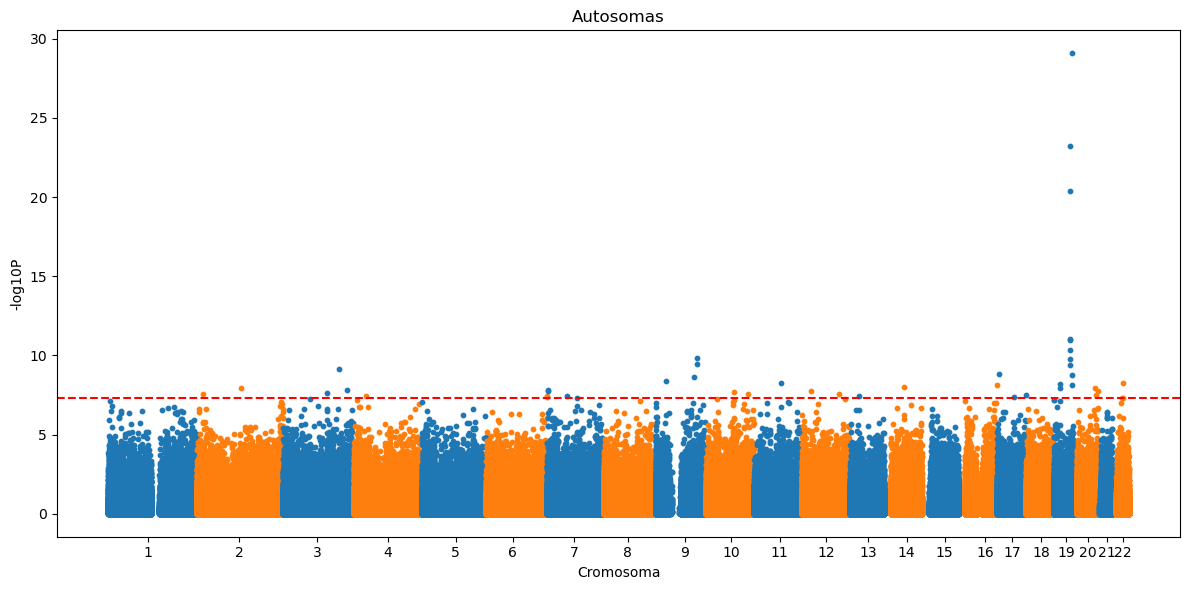

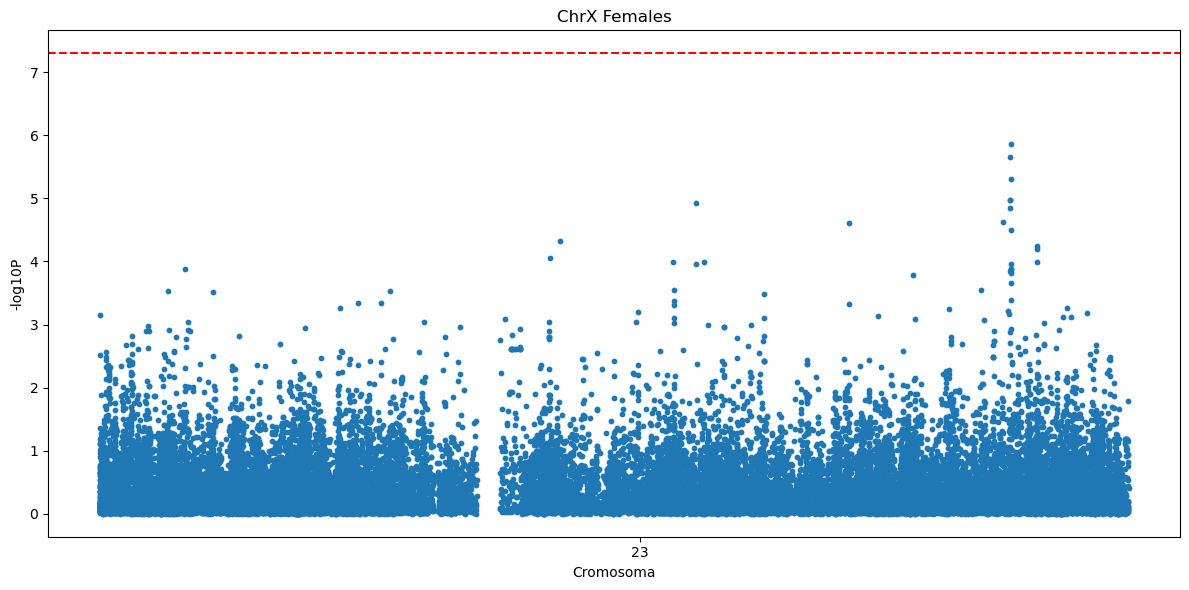

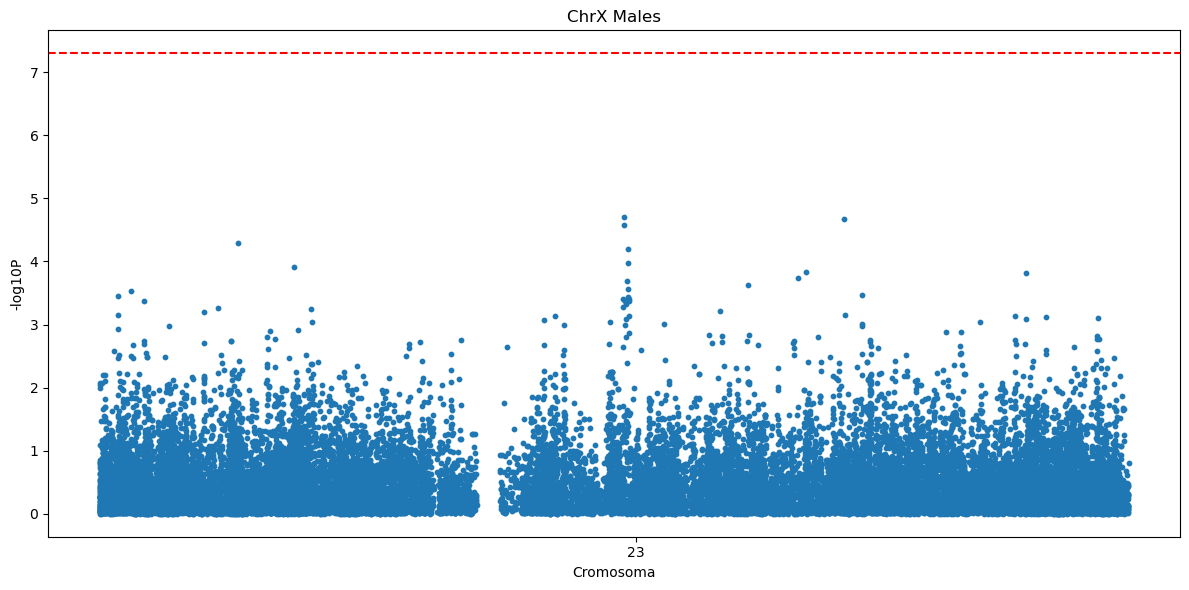

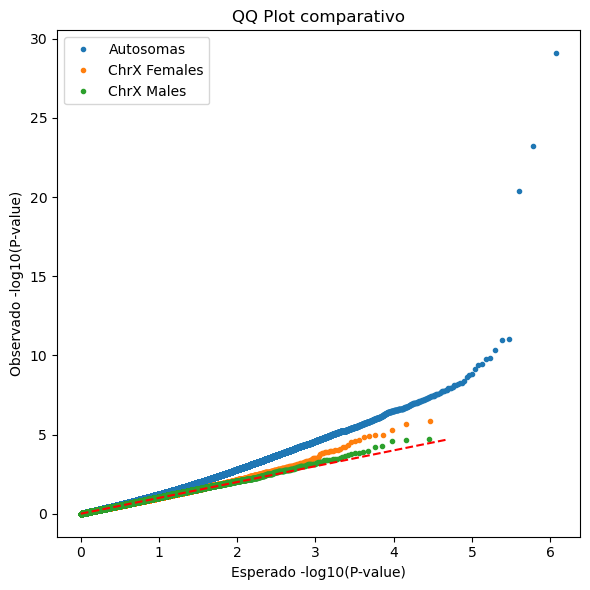

In [339]:
# Archivos de salida de METAL con CHR y BP añadidos
autosomas = "adni_all_plink/METAL_chr_bp/analisis_meta_autosomes1_chr_bp.tbl"
females = "adni_all_plink/METAL_chr_bp/analisis_meta_chrX_females1_chr_bp.tbl"
males = "adni_all_plink/METAL_chr_bp/analisis_meta_chrX_males1_chr_bp.tbl"

# Generar Manhattan plots individuales
manhattan_plot(autosomas, f"{graf}/manhattan_autosomas.png", "Autosomas")
manhattan_plot(females, f"{graf}/manhattan_chrX_females.png", "ChrX Females")
manhattan_plot(males, f"{graf}/manhattan_chrX_males.png", "ChrX Males")

# Generar QQ-plot comparativo
qq_plot(
    [autosomas, females, males],
    ["Autosomas", "ChrX Females", "ChrX Males"],
    f"{graf}/qqplot_comparativo.png",
    "QQ Plot comparativo"
)

### 7. Mapeado de rsIDs

In [353]:
# 1. Calcular rsIDs significativos
output_dir = "adni_all_plink/Mapeado"
os.makedirs(output_dir, exist_ok=True) #Crea la carpeta adni_all_plink, si no existe
# Cargar datos
metal_results_file = "adni_all_plink/METAL_chr_bp/analisis_meta_autosomes1_chr_bp.tbl"
metal_results = pd.read_csv(metal_results_file, sep="\t")

# --- Ajuste por FDR (Benjamini–Hochberg) a nivel SNP ---
# Seleccionar columna P-value y el metodo mencionado
# reject sirve para confirmar o rechazar la hipótesis nula
# p_adj son los p-values ajustados
# los _ se colocan porque esos dos valores casi nunca se usan
reject, p_adj, _, _ = multipletests(metal_results["P-value"], method="fdr_bh")

# Añadir resultados al dataframe
metal_results["FDR"] = p_adj
metal_results["significant"] = reject # Permite saber que SNPs son significativos (True)

# Guardar los SNPs con FDR < 0.05
sig_snps = metal_results[metal_results["significant"]]

# Guardar todos los resultados con FDR
metal_results.to_csv("all_snps_with_fdr.tsv", sep="\t", index=False)

# Guardar solo los resultados significativos
sig_snps.to_csv(f"{os.path.join(output_dir, "significant_snps.tsv")}", sep="\t", index=False)

# --- Ajuste por umbral genome-wide ---
metal_results_1 = pd.read_csv(metal_results_file, sep="\t")

genomewide_snps = metal_results[metal_results_1["P-value"] < 5e-8]

# Guardar resultados
genomewide_snps.to_csv("significant_snps_genomewide.tsv", sep="\t", index=False)

print(f"Total SNPs: {metal_results.shape[0]}")
print(f"SNPs significativos (FDR < 0.05): {sig_snps.shape[0]}")
print(f"SNPs significativos con P < 5e-8: {genomewide_snps.shape[0]}")
print(sig_snps.head())

Total SNPs: 1196303
SNPs significativos (FDR < 0.05): 2673
SNPs significativos con P < 5e-8: 44
           MarkerName Allele1 Allele2  Effect  StdErr   P-value Direction  \
698        rs28728260       t       c -0.1474  0.0380  0.000105      --??   
895   1:178518008:A:G       a       g -0.2172  0.0471  0.000004      --??   
1636       rs16943349       a       g  0.4006  0.0979  0.000043      ++??   
3595         rs789643       a       g -0.3176  0.0703  0.000006      --??   
5124        rs3016880       t       c  0.2235  0.0493  0.000006      ++??   

      HetISq  HetChiSq  HetDf  HetPVal  CHR         BP       FDR  significant  
698     17.9     1.218      1  0.26980    3   71477708  0.048501         True  
895     76.5     4.259      1  0.03905    1  178518008  0.011342         True  
1636     0.0     0.841      1  0.35910   15   61215898  0.032733         True  
3595     0.0     0.446      1  0.50440    1  232680597  0.013360         True  
5124    63.5     2.740      1  0.09785   

In [377]:
# 2. Cargar el archivo
file_path = "adni_all_plink/Mapeado/significant_snps.tsv"
df = pd.read_csv(file_path, sep="\t")

output_dir = "adni_all_plink/Mapeado"

# 3. Mirar columnas para identificar dónde están los rsIDs
print("Columnas detectadas:", df.columns.tolist())
print(df.head())
# En este caso la columna se llama MarkerName
col_rsid = "MarkerName"

Columnas detectadas: ['MarkerName', 'Allele1', 'Allele2', 'Effect', 'StdErr', 'P-value', 'Direction', 'HetISq', 'HetChiSq', 'HetDf', 'HetPVal', 'CHR', 'BP', 'FDR', 'significant']
        MarkerName Allele1 Allele2  Effect  StdErr   P-value Direction  \
0       rs28728260       t       c -0.1474  0.0380  0.000105      --??   
1  1:178518008:A:G       a       g -0.2172  0.0471  0.000004      --??   
2       rs16943349       a       g  0.4006  0.0979  0.000043      ++??   
3         rs789643       a       g -0.3176  0.0703  0.000006      --??   
4        rs3016880       t       c  0.2235  0.0493  0.000006      ++??   

   HetISq  HetChiSq  HetDf  HetPVal  CHR         BP       FDR  significant  
0    17.9     1.218      1  0.26980    3   71477708  0.048501         True  
1    76.5     4.259      1  0.03905    1  178518008  0.011342         True  
2     0.0     0.841      1  0.35910   15   61215898  0.032733         True  
3     0.0     0.446      1  0.50440    1  232680597  0.013360       

In [378]:
# 4. Extraer rsIDs, quitar duplicados, limpiar prefijos raros
rsids = (df[col_rsid]
         .astype(str) # Convertir a string
         .str.strip() # Elimina caracteres del principio y final del string (espacios en blanco, tabuladores o saltos de linea)
         .dropna() # Eliminar filas sin valor en el ID
         .drop_duplicates()) # Eliminar duplicados

# Separar los dos tipos de prefijos en archivos distintos
rsids_rs = rsids[rsids.str.startswith("rs")]
rsids_other_id = rsids[~rsids.str.startswith("rs")]

print(f"Despues del filtrado de duplicados tenemos: {len(rsids_rs)} rsIDs y {len(rsids_other_id)} CHR:BP:A1:A2")

Despues del filtrado de duplicados tenemos: 2445 rsIDs y 228 CHR:BP:A1:A2


In [379]:
# 5. Guardar en archivo de texto (un rsID por línea) los significativos
rsids_rs.to_csv("adni_all_plink/Mapeado/rsid_list.txt", index=False, header=False)
rsids_other_id.to_csv("adni_all_plink/Mapeado/other_id_list.txt", index=False, header=False)

print(rsids_rs.head())
print(rsids_other_id.head())

0    rs28728260
2    rs16943349
3      rs789643
4     rs3016880
5    rs34807617
Name: MarkerName, dtype: object
1      1:178518008:A:G
23      4:11216238:T:C
72      7:55855180:A:G
116    7:139447377:C:A
124     9:92260403:G:A
Name: MarkerName, dtype: object


Se mapearon estas dos listas en Ensembl con el genoma de referencia GRCh37 (https://grch37.ensembl.org/biomart/martview/06168cc042a46083ab4d3de78a3a8c1b) para conseguir el Gene Name correspondiente, pero la segunda lista no se pudo reconocer así que a partir de aquí seguimos únicamente con los datos de rsIDs

In [380]:
# Leer el archivo de Ensembl 
input_pattern = "../../Descargas/mart_export.txt"  
output_file = "adni_all_plink/Mapeado/all_genes_filtered.tsv"

df = pd.read_csv(input_pattern, sep="\t")
print(df.head())

# Filtrar filas donde las columnas 2 y 3 están vacías
filtered_df = df[
    df.iloc[:,1].notnull() & (df.iloc[:,1] != "") &
    df.iloc[:,2].notnull() & (df.iloc[:,2] != "")
]

# Guardar el archivo limpio
filtered_df.to_csv(output_file, index=False, sep="\t")
print(f"Archivo final guardado en {output_file} con {filtered_df.shape[0]} filas.")
print(filtered_df.head())

  Variant name        Gene Name   Gene stable ID
0   rs35383955  ENSG00000236423  ENSG00000236423
1   rs35383955  ENSG00000236423  ENSG00000236423
2   rs35383955  ENSG00000268811  ENSG00000268811
3   rs35383955  ENSG00000268811  ENSG00000268811
4   rs35764831              NaN              NaN
Archivo final guardado en adni_all_plink/Mapeado/all_genes_filtered.tsv con 2491 filas.
  Variant name        Gene Name   Gene stable ID
0   rs35383955  ENSG00000236423  ENSG00000236423
1   rs35383955  ENSG00000236423  ENSG00000236423
2   rs35383955  ENSG00000268811  ENSG00000268811
3   rs35383955  ENSG00000268811  ENSG00000268811
6   rs55717234  ENSG00000143363  ENSG00000143363


In [381]:
# Leer archivo anterior
df = pd.read_csv("adni_all_plink/Mapeado/all_genes_filtered.tsv", sep="\t")
# Elimina duplicados exactos según las 3 columnas
df_nodup = df.drop_duplicates(subset=["Variant name", "Gene Name", "Gene stable ID"])
df_nodup.to_csv("adni_all_plink/Mapeado/human_genes.tsv", index=False, sep="\t")
print(f"De {len(df)} filas a {len(df_nodup)} filas únicas.")
print(df_nodup.head())

De 2491 filas a 1352 filas únicas.
  Variant name        Gene Name   Gene stable ID
0   rs35383955  ENSG00000236423  ENSG00000236423
2   rs35383955  ENSG00000268811  ENSG00000268811
4   rs55717234  ENSG00000143363  ENSG00000143363
6   rs12092145  ENSG00000162849  ENSG00000162849
7   rs12119170  ENSG00000177181  ENSG00000177181


In [382]:
# Cargar archivo anterior
genes = pd.read_csv("adni_all_plink/Mapeado/human_genes.tsv", sep="\t")

# Seleccionar la columna Gene stable ID
human_genes = genes["Gene stable ID"].dropna().unique()

# Guardar en CSV para el análisis posterior
pd.Series(human_genes).to_csv("adni_all_plink/Mapeado/human_genes.csv", index=False, header=False)

print(f"Tenemos {len(human_genes)} ID de genes únicos")

Tenemos 1025 ID de genes únicos


Mapear este archivo para conseguir las variantes homologas en ratones, esta vez en el genoma de referencia GRCh38 (https://www.ensembl.org/biomart/martview/bd54fd7f266e2243e5f470b80cc2f528) que si tiene la opción en Ensembl para hacer esto. Como ahora lo único que tenemos es el ID del gen no pasa nada si lo mapeamos con el otro genoma.

In [383]:
# Leer archivo TSV obtenido del ensembl con el archivo human_genes.csv
df = pd.read_csv("../../Descargas/mart_export(1).txt", sep="\t")
print(df.head())

# Eliminar filas donde Mouse gene stable ID o Mouse gene name estén vacíos
df_clean = df.dropna(subset=["Mouse gene stable ID", "Mouse gene name"])

# Guardar archivo limpio
df_clean.to_csv("adni_all_plink/Mapeado/human_mouse_orthologs_clean.tsv", sep="\t", index=False)

print(f"Archivo limpio guardado con {len(df_clean)} filas.")
print(df_clean.head())

    Gene stable ID Mouse gene stable ID Mouse gene name
0  ENSG00000000971                  NaN             NaN
1  ENSG00000002822   ENSMUSG00000029554          Mad1l1
2  ENSG00000003987   ENSMUSG00000039431           Mtmr7
3  ENSG00000004948   ENSMUSG00000023964           Calcr
4  ENSG00000005339   ENSMUSG00000022521          Crebbp
Archivo limpio guardado con 733 filas.
    Gene stable ID Mouse gene stable ID Mouse gene name
1  ENSG00000002822   ENSMUSG00000029554          Mad1l1
2  ENSG00000003987   ENSMUSG00000039431           Mtmr7
3  ENSG00000004948   ENSMUSG00000023964           Calcr
4  ENSG00000005339   ENSMUSG00000022521          Crebbp
5  ENSG00000006740   ENSMUSG00000033389        Arhgap44


In [384]:
# Cargar tu tabla SNP->Human->Mouse
snp2mouse = pd.read_csv("adni_all_plink/Mapeado/human_mouse_orthologs_clean.tsv", sep="\t")

# Eliminar duplicados de genes de ratón
mouse_genes = pd.Series(snp2mouse['Mouse gene name'].dropna().unique()).sort_values()
mouse_genes.to_csv("adni_all_plink/Mapeado/mouse_genes.txt", index=False, header=False)

print(f"{len(mouse_genes)} genes de ratón únicos")

733 genes de ratón únicos


In [385]:
# Filtración genes significativos de ratón en Alzheimer mediante tablas DEG
tablas = [
    "../../Descargas/deg_3xTG_AD.csv",
    "../../Descargas/deg_5xFAD.csv",
    "../../Descargas/deg_PS3O1S.csv"
]

for tabla in tablas:
    # Leer el archivo DEG
    df_tabla = pd.read_csv(tabla)
    if os.path.basename(tabla) == "deg_PS3O1S.csv":
        # Filtrar por p_adj < 0.05
        sig_tabla = df_tabla[df_tabla["qval"] < 0.05]
    else:
        # Filtrar por p_adj < 0.05
        sig_tabla = df_tabla[df_tabla["p_adj"] < 0.05]
    # Guardar resultados
    sig_tabla.to_csv(f"adni_all_plink/Mapeado/sig_{os.path.basename(tabla)}")
    print(f"{len(sig_tabla)} genes significativos encontrados en {os.path.basename(tabla)}")

42 genes significativos encontrados en deg_3xTG_AD.csv
410 genes significativos encontrados en deg_5xFAD.csv
0 genes significativos encontrados en deg_PS3O1S.csv


In [386]:
# Cargar ambos archivos de genes significativos en ratón
df_3xTG = pd.read_csv("adni_all_plink/Mapeado/sig_deg_3xTG_AD.csv")
df_5xFAD = pd.read_csv("adni_all_plink/Mapeado/sig_deg_5xFAD.csv")

# Concatenar uno detrás del otro
df_concat = pd.concat([df_3xTG, df_5xFAD], ignore_index=True)

# Eliminar duplicados por 'Gene_Name' si existen
df_unique = df_concat.drop_duplicates(subset=["Gene_Name"])

# Guardar resultado
df_unique.to_csv("adni_all_plink/Mapeado/DE_significativos_union.csv", index=False)

print(f"Hay {len(df_unique)} genes significativos en raton")

Hay 450 genes significativos en raton


In [388]:
# Cargar archivo unido de genes significativos
df_union = pd.read_csv("adni_all_plink/Mapeado/DE_significativos_union.csv")

# Cargar lista de genes de ratón ortólogos
with open("adni_all_plink/Mapeado/mouse_genes.txt") as f:
    mouse_genes = set(line.strip() for line in f if line.strip())

# Filtrar solo los genes presentes en mouse_genes
df_mouse = df_union[df_union["Gene_Name"].isin(mouse_genes)]

# Guardar resultado
df_mouse.to_csv("adni_all_plink/Mapeado/genes_sig_overlap.csv", index=False)

print(f"Se encontraron {len(df_mouse)} genes homologos significativos tanto en humanos como en ratones")
print(df_mouse.head())

Se encontraron 16 genes homologos significativos tanto en humanos como en ratones
     Unnamed: 0.1  Unnamed: 0                gene Gene_Name    log2fc  \
27            104       15209  ENSMUSG00000074852     Hpse2  2.505115   
56             15         389  ENSMUSG00000002699      Lcp2  1.063879   
92             53        1670  ENSMUSG00000018654     Ikzf1  0.834701   
101            64        1966  ENSMUSG00000020101      Vsir  1.111386   
103            66        2044  ENSMUSG00000020256   Aldh1l2  1.061034   

        t_stat     p_val     p_adj  abs_log2fc  
27   15.052203  0.000114  0.048980    2.505115  
56    5.063743  0.000081  0.006754    1.063879  
92    3.839426  0.001201  0.035860    0.834701  
101   4.670928  0.000190  0.011187    1.111386  
103   3.713866  0.001589  0.043942    1.061034  


### 8. Representacion resultados

In [391]:
# Cargar tu tabla significativos overlap
snp2mouse = pd.read_csv("adni_all_plink/Mapeado/genes_sig_overlap.csv")

# Eliminar duplicados de genes de ratón
mouse_genes_overlap = pd.Series(snp2mouse['Gene_Name'].dropna().unique()).sort_values()
mouse_genes_overlap.to_csv("adni_all_plink/Mapeado/mouse_genes_overlap.txt", index=False, header=False)

In [393]:
# Cargar archivo ortologos clean
df_ortholog = pd.read_csv("adni_all_plink/Mapeado/human_mouse_orthologs_clean.tsv", sep="\t")

# Cargar lista de genes de ratón ortólogos
with open("adni_all_plink/Mapeado/mouse_genes_overlap.txt") as f:
    mouse_genes_final = set(line.strip() for line in f if line.strip())

# Filtrar solo los genes presentes en mouse_genes
df_mouse = df_ortholog[df_ortholog["Mouse gene name"].isin(mouse_genes_final)]

# Guardar resultado
df_mouse.to_csv("adni_all_plink/Mapeado/genes_sig_humanos.tsv",sep="\t" , index=False)

In [396]:
# Cargar tu tabla Gen ID human->Gen ID mouse->Mouse gen name
sigmouse = pd.read_csv("adni_all_plink/Mapeado/human_mouse_orthologs_clean.tsv", sep="\t")

sigmouse_genes = pd.Series(sigmouse['Gene stable ID'].dropna().unique()).sort_values()
sigmouse_genes.to_csv("adni_all_plink/Mapeado/significativos_ortologos_genes.txt", index=False, header=False)

In [416]:
# Cargar tu tabla Gen ID human->Gen ID mouse->Mouse gen name
sigoverlap = pd.read_csv("adni_all_plink/Mapeado/genes_sig_humanos.tsv", sep="\t")

sigoverlap_genes = pd.Series(sigoverlap['Gene stable ID'].dropna().unique()).sort_values()
sigoverlap_genes.to_csv("adni_all_plink/Mapeado/significativos_overlap_human_genes.txt", index=False, header=False)

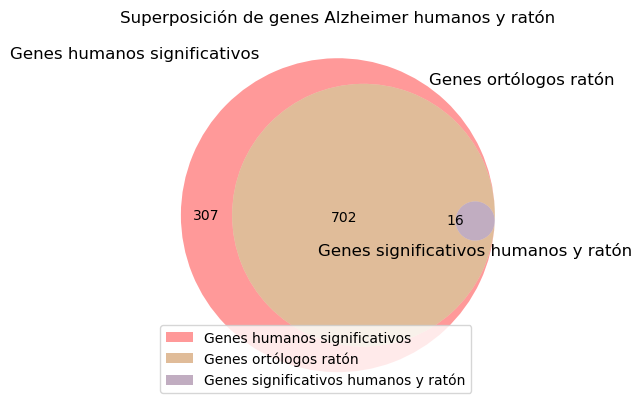

In [471]:
# Graficar resultados
# Cargar listas de genes
with open("adni_all_plink/Mapeado/human_genes.csv") as f:
    genes_human = set(line.strip() for line in f if line.strip())
with open("adni_all_plink/Mapeado/significativos_overlap_human_genes.txt") as f:
    genes_overlap = set(line.strip() for line in f if line.strip())
with open("adni_all_plink/Mapeado/significativos_ortologos_genes.txt") as f:
    genes_mouse = set(line.strip() for line in f if line.strip())

# Crear diagrama de Venn
venn = venn3([genes_human, genes_mouse, genes_overlap], set_labels=("Genes humanos significativos", "Genes ortólogos ratón", "Genes significativos humanos y ratón"))

plt.legend(["Genes humanos significativos", "Genes ortólogos ratón", "Genes significativos humanos y ratón"], loc="best")
plt.title("Superposición de genes Alzheimer humanos y ratón")
plt.savefig("adni_all_plink/Graficas/Venn_human_mouse", dpi=300)
plt.show()

In [412]:
# Cargar tu tabla significativos raton
sigmouse = pd.read_csv("adni_all_plink/Mapeado/DE_significativos_union.csv")

sigmouse_genes = pd.Series(sigmouse['Gene_Name'].dropna().unique()).sort_values()
sigmouse_genes.to_csv("adni_all_plink/Mapeado/significativos_mouse_genes.txt", index=False, header=False)

In [414]:
# Cargar tu tabla overlap raton
sigmouse = pd.read_csv("adni_all_plink/Mapeado/genes_sig_overlap.csv")

sigmouse_genes = pd.Series(sigmouse['Gene_Name'].dropna().unique()).sort_values()
sigmouse_genes.to_csv("adni_all_plink/Mapeado/significativos_overlap_mouse_genes.txt", index=False, header=False)

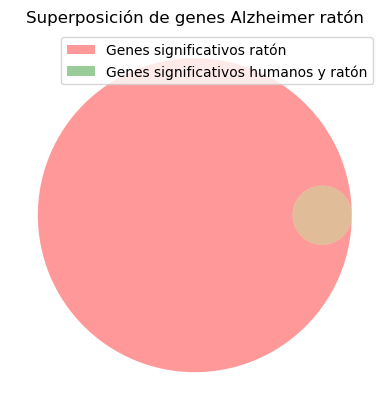

In [468]:
# Graficar resultados
# Cargar listas de genes
with open("adni_all_plink/Mapeado/significativos_overlap_mouse_genes.txt") as f:
    genes_overlap = set(line.strip() for line in f if line.strip())
with open("adni_all_plink/Mapeado/significativos_mouse_genes.txt") as f:
    genes_mouse = set(line.strip() for line in f if line.strip())

# Crear diagrama de Venn
venn_1 = venn2([genes_mouse, genes_overlap], set_labels=("Genes significativos ratón", "Genes significativos humanos y ratón"))
for text in venn_1.set_labels:
    text.set_text("")
for text in venn_1.subset_labels:
    if text:
        text.set_text("")
# Crear handles manuales para la leyenda con los mismos colores reales porque sino pueden no coincidir leyenda y gráfico
handles = [
    plt.Line2D([0], [0], color="red", lw=0, marker="o", markersize=15),     # color del primer conjunto
    plt.Line2D([0], [0], color="green", lw=0, marker="o", markersize=15),   # color de la intersección (forzado a marrón)
]

plt.legend(handles, ["Genes significativos ratón", "Genes significativos humanos y ratón"], loc="best")
plt.legend(["Genes significativos ratón", "Genes significativos humanos y ratón"], loc="best")
plt.title("Superposición de genes Alzheimer ratón")
plt.savefig("adni_all_plink/Graficas/Venn_mouse", dpi=300)
plt.show()

### 9. Interpretación funcional

In [ ]:
"adni_all_plink/Mapeado/significativos_overlap_human_genes.txt" # Solo gene stable ID humano

"adni_all_plink/Mapeado/significativos_overlap_mouse_genes.txt" # Solo mouse gene name

In [439]:
# Encontrar el GeneSymbol de los genes significativos en común humano
output_dir = "adni_all_plink/Enriquecimiento"
os.makedirs(output_dir, exist_ok=True) #Crea la carpeta adni_all_plink, si no existe

# Cargar tus ENSG IDs
ensg = pd.read_csv("adni_all_plink/Mapeado/significativos_overlap_human_genes.txt")

# Conectar a mygene
mg = mygene.MyGeneInfo()

# Query para traducir ENSG → Symbol
out = mg.querymany(ensg, scopes="ensembl.gene", fields="symbol", species="human")

# Pasar a DataFrame
df = pd.DataFrame(out)[["query", "symbol"]].dropna()
df.columns = ["ENSG", "GeneSymbol"]

# Seleccionar solo la segunda columna (GeneSymbol)
df_symbol = df[["GeneSymbol"]].drop_duplicates()

# Guardar
df_symbol.to_csv(f"{output_dir}/gene_symbols_human.csv", index=False)
print(df_symbol.head())

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


  GeneSymbol
0       LCP2


#### Comparacion funcional / vias

In [4]:
# 1. Cargar lista de genes
genes = pd.read_csv("adni_all_plink/Enriquecimiento/gene_symbols_human.csv")["GeneSymbol"].dropna().unique().tolist()

# 2. Enriquecimiento con Enrichr (KEGG y Reactome)
enr = gp.enrichr(
    gene_list=genes,
    gene_sets=["KEGG_2021_Human", "Reactome_2022","GO_Biological_Process_2025","GO_Biological_Process_2023"],
    organism="Human",
    cutoff=0.05,  # FDR < 0.05
)

# 3. Guardar resultados
results = enr.results
results.to_csv("adni_all_plink/Enriquecimiento/human_pathway_enrichment.csv", index=False)
print(results)

                      Gene_set  \
0              KEGG_2021_Human   
1              KEGG_2021_Human   
2              KEGG_2021_Human   
3              KEGG_2021_Human   
4              KEGG_2021_Human   
5              KEGG_2021_Human   
6              KEGG_2021_Human   
7                Reactome_2022   
8                Reactome_2022   
9                Reactome_2022   
10               Reactome_2022   
11               Reactome_2022   
12               Reactome_2022   
13               Reactome_2022   
14               Reactome_2022   
15               Reactome_2022   
16               Reactome_2022   
17               Reactome_2022   
18               Reactome_2022   
19               Reactome_2022   
20  GO_Biological_Process_2025   
21  GO_Biological_Process_2025   
22  GO_Biological_Process_2025   
23  GO_Biological_Process_2025   
24  GO_Biological_Process_2025   
25  GO_Biological_Process_2025   
26  GO_Biological_Process_2025   
27  GO_Biological_Process_2025   
28  GO_Biologi

In [5]:
# Diccionario de pathways conocidos asociados a Alzheimer
alzheim_pathways_ref_human = {
    "KEGG_Alzheimer": "hsa05010",
    "Reactome_Alzheimer": "R-HSA-1620370",
    "KEGG_Agents_for_Alzheimer" : "map07056",
    "KEGG_Parkinson": "hsa05012",
    "KEGG_Huntington": "hsa05016",
    "Pathways_neurodegeneration": "hsa05022",
    "Neuroinflammation": "GO:0006954",
    "Synaptic_transmission": "GO:0007268",
    "Tau_protein_binding": "GO:0048156",
    "Amyloid_beta_clearance": "GO:0097242",
    "Oxidative_stress": "GO:0006979",
    "Alzheimer" : ["alzheimer", "neuroinflammation", "autophagy", "synapse", "memory", "axon", 
                   "dendrite", "microglia", "astrocyte","tau pathology"]
}

In [6]:
# Cargar tus resultados de pathways (GO/KEGG/Reactome)
pathways = pd.read_csv("adni_all_plink/Enriquecimiento/human_pathway_enrichment.csv", sep=",")

# Normalizamos a minúsculas para facilitar búsqueda
pathways["term_lower"] = pathways["Term"].str.lower()
matches = []
for name, ref in alzheim_pathways_ref_human.items():
    if isinstance(ref, list):
        # Si es una lista de keywords → buscar cualquiera de ellas
        # Usamos lower() para cada keyword y cada término
        mask = pathways["term_lower"].apply(lambda x: any(kw.lower() in x for kw in ref))
    else:
        # Si es string normal → buscar directamente
        mask = pathways["term_lower"].str.contains(name.split("_")[0].lower(), na=False) | \
           pathways["term_lower"].str.contains(ref.lower(), na=False)
    
    subset = pathways[mask].copy()
    if not subset.empty:
        subset["reference"] = name
        matches.append(subset)

# Concatenar todas las coincidencias (si hay)
if matches:
    alzheim_matches = pd.concat(matches).drop_duplicates()
    alzheim_matches.to_csv("alzheim_relevant_pathways.csv", sep="\t", index=False)
    print(f"Se encontraron {len(alzheim_matches)} pathways relevantes relacionados con Alzheimer.")
else:
    alzheim_matches = pd.DataFrame()
    print("No se encontraron pathways relevantes relacionados con Alzheimer humano.")
print(alzheim_matches)

No se encontraron pathways relevantes relacionados con Alzheimer humano.
Empty DataFrame
Columns: []
Index: []


In [7]:
# Saber que librerías dispone enrichr
libs = gp.get_library_name()  
print(libs)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'COMPARTMENTS_Curated_2025', 'COMPARTMENTS_Experimental_2025', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'ClinVar_2025', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency_CellLines_2023', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_201

In [8]:
# Cargar lista de genes (debe ser símbolo oficial, uno por línea)
with open("adni_all_plink/Mapeado/significativos_overlap_mouse_genes.txt") as f:
    genes = [line.strip() for line in f if line.strip()]

gene_sets = ['GO_Biological_Process_2023', 'KEGG_2019_Mouse', 'Reactome_2022']

enr = gp.enrichr(
    gene_list=genes,
    gene_sets=gene_sets,
    organism='Mouse',
    outdir='adni_all_plink/Enriquecimiento/resultados_enrichr_mouse',
    cutoff=0.05
)

# Mostrar los resultados principales
for name, res in enr.results.items():
    print(f'\nResultados para {name}:\n')
    print(res.head())


Resultados para Gene_set:

0    GO_Biological_Process_2023
1    GO_Biological_Process_2023
2    GO_Biological_Process_2023
3    GO_Biological_Process_2023
4    GO_Biological_Process_2023
Name: Gene_set, dtype: object

Resultados para Term:

0    Cellular Response To Bacterial Lipopeptide (GO...
1    Regulation Of Toll-Like Receptor 2 Signaling P...
2    Positive Regulation Of Interleukin-6 Productio...
3    Regulation Of Interleukin-6 Production (GO:003...
4    Regulation Of Tumor Necrosis Factor Production...
Name: Term, dtype: object

Resultados para Overlap:

0      2/6
1     2/10
2     3/76
3    3/114
4    3/127
Name: Overlap, dtype: object

Resultados para P-value:

0    0.000009
1    0.000027
2    0.000028
3    0.000096
4    0.000132
Name: P-value, dtype: float64

Resultados para Adjusted P-value:

0    0.002174
1    0.002299
2    0.002299
3    0.004747
4    0.004747
Name: Adjusted P-value, dtype: float64

Resultados para Old P-value:

0    0
1    0
2    0
3    0
4    0
Name: Ol

In [9]:
# Diccionario de pathways conocidos asociados a Alzheimer mouse
alzheim_pathways_raton = {
    "KEGG_Alzheimer": "mmu05010",
    "Reactome_Alzheimer": "R-HSA-1620370",
    "KEGG_Parkinson": "mmu05012",
    "KEGG_Huntington": "mmu05016",
    "Neuroinflammation": "GO:0006954",
    "Synaptic_transmission": "GO:0007268",
    "Tau_protein_binding": "GO:0048156",
    "Amyloid_beta_clearance": "GO:0097242",
    "Oxidative_stress": "GO:0006979"
}

In [10]:
# Cargar tus resultados de pathways (GO/KEGG/Reactome)
pathways_rat = pd.read_csv("adni_all_plink/Enriquecimiento/resultados_enrichr_mouse/GO_Biological_Process_2023.Mouse.enrichr.reports.txt", sep="\t")

# Normalizamos a minúsculas para facilitar búsqueda
pathways_rat["term_lower"] = pathways_rat["Term"].str.lower()
matches_rat = []
for name, ref in alzheim_pathways_raton.items():
    if isinstance(ref, list):
        # Si es una lista de keywords → buscar cualquiera de ellas
        # Usamos lower() para cada keyword y cada término
        mask_rat = pathways_rat["term_lower"].apply(lambda x: any(kw.lower() in x for kw in ref))
    else:
        # Si es string normal → buscar directamente
        mask_rat = pathways_rat["term_lower"].str.contains(name.split("_")[0].lower(), na=False) | \
           pathways_rat["term_lower"].str.contains(ref.lower(), na=False)
    
    subset_rat = pathways_rat[mask_rat].copy()
    if not subset_rat.empty:
        subset_rat["reference"] = name
        matches_rat.append(subset_rat)

# Concatenar todas las coincidencias (si hay)
if matches_rat:
    alzheim_matches_rat = pd.concat(matches_rat).drop_duplicates()
    alzheim_matches_rat.to_csv("adni_all_plink/Enriquecimiento/alzheim_relevant_pathways_raton.csv", sep="\t", index=False)
    print(f"Se encontraron {len(alzheim_matches_rat)} pathways relevantes relacionados con Alzheimer.")
else:
    alzheim_matches_rat = pd.DataFrame()
    print("No se encontraron pathways relevantes relacionados con Alzheimer.")
print(alzheim_matches_rat)

Se encontraron 3 pathways relevantes relacionados con Alzheimer.
                       Gene_set  \
87   GO_Biological_Process_2023   
124  GO_Biological_Process_2023   
137  GO_Biological_Process_2023   

                                               Term Overlap   P-value  \
87               Inflammatory Response (GO:0006954)   2/236  0.014921   
124  Cellular Response To Amyloid-Beta (GO:1904646)    1/34  0.026866   
137           Response To Amyloid-Beta (GO:1904645)    1/43  0.033863   

     Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
87           0.039713            0                     0    12.05739   
124          0.051599            0                     0    40.30505   
137          0.059383            0                     0    31.65397   

     Combined Score      Genes  \
87         50.70111  TLR1;TLR6   
124       145.77950       TLR6   
137       107.16230       TLR6   

                                         term_lower               reference